In [17]:
import stumpy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import math
import os
import sys
import logging
logging.basicConfig(level=logging.INFO)

In [18]:
current = os.path.dirname(os.path.realpath(sys.argv[0]))
parent = os.path.dirname(current)
sys.path.append(parent)

from MSig import Motif, NullModel

In [19]:
#read the data
colnames = ["timestamp","current","power_factor", "water_monitoring_inlet", "water_monitoring_outlet","water_temperature_inlet", "water_temperature_outlet"]
data = pd.read_csv("../data/washingmachine/main_readings.csv", usecols=colnames)
#data_accellerometer = pd.read_csv("../data/washingmachine/main_readings_accelerometer.csv")
#change timestamp from float to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
#drop the microsecond part
data['timestamp'] = data['timestamp'].dt.floor('s')
#remove readings in same second
data = data.drop_duplicates(subset='timestamp', keep='first')
#assume first as 00:00:00 of the day
first_datetime = data['timestamp'].iloc[0]
time_diff = data['timestamp'].apply(lambda x: x - first_datetime)
first_datetime = first_datetime.replace(hour=0, minute=0, second=0)
data['timestamp'] = first_datetime + time_diff
data = data.set_index('timestamp')
data




current  power_factor  water_monitoring_inlet  \
timestamp                                                            
2023-07-14 00:00:00    0.064          0.00                     0.0   
2023-07-14 00:00:01    0.064          0.00                     0.0   
2023-07-14 00:00:02    0.064          0.00                     0.0   
2023-07-14 00:00:03    0.065          0.00                     0.0   
2023-07-14 00:00:04    0.065          0.00                     0.0   
...                      ...           ...                     ...   
2023-07-14 03:55:02    0.064          0.03                     0.0   
2023-07-14 03:55:03    0.064          0.03                     0.0   
2023-07-14 03:55:04    0.064          0.03                     0.0   
2023-07-14 03:55:05    0.064          0.03                     0.0   
2023-07-14 03:55:06    0.064          0.03                     0.0   

                     water_monitoring_outlet  water_temperature_inlet  \
timestamp                                                               
2023-07-14 00:00:00                      0.0                  17.6250   
2023-07-14 00:00:01                      0.0                  17.0625   
2023-07-14 00:00:02                      0.0                  17.0000   
2023-07-14 00:00:03                      0.0                  17.0625   
2023-07-14 00:00:04                      0.0                  17.0625   
...                                      ...                      ...   
2023-07-14 03:55:02                      0.0                  18.5000   
2023-07-14 03:55:03                      0.0                  18.5000   
2023-07-14 03:55:04                      0.0                  18.5000   
2023-07-14 03:55:05                      0.0                  18.5000   
2023-07-14 03:55:06                      0.0                  18.5000   

                     water_temperature_outlet  
timestamp                                      
2023-07-14 00:00:00                   18.5000  
2023-07-14 00:00:01                   17.1250  
2023-07-14 00:00:02                   17.1250  
2023-07-14 00:00:03                   17.1250  
2023-07-14 00:00:04                   17.1875  
...                                       ...  
2023-07-14 03:55:02                   20.5000  
2023-07-14 03:55:03                   20.5000  
2023-07-14 03:55:04                   20.5000  
2023-07-14 03:55:05                   20.5000  
2023-07-14 03:55:06                   20.5000  

[14101 rows x 6 columns]

In [20]:
#aggregate accelerometer readings by second
#change date to timestamp
# data_accellerometer['timestamp'] = pd.to_datetime(data_accellerometer['date'])
# data_accellerometer = data_accellerometer.set_index('timestamp')
# data_accellerometer = data_accellerometer.resample('s').mean()
# data_accellerometer = data_accellerometer.reset_index()
# data_accellerometer["timestamp"] = pd.to_datetime(data_accellerometer["timestamp"])
# data_accellerometer['timestamp'] = data_accellerometer['timestamp'].dt.floor('s')
# data_accellerometer['timestamp'] = data_accellerometer['timestamp'].dt.tz_localize(None)
# data_accellerometer = data_accellerometer.dropna()

#join the two dataframes

#data_accellerometer = data_accellerometer.set_index('timestamp')
#data = data.join(data_accellerometer, how='inner')
#data = data.drop(columns=['voltage', "frequency", "power_factor"])
#features = data.columns.tolist()
#data

In [21]:
#data to numpy ndarray
X = data.to_numpy().astype(np.float64).T
X

array([[ 0.064 ,  0.064 ,  0.064 , ...,  0.064 ,  0.064 ,  0.064 ],
       [ 0.    ,  0.    ,  0.    , ...,  0.03  ,  0.03  ,  0.03  ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [17.625 , 17.0625, 17.    , ..., 18.5   , 18.5   , 18.5   ],
       [18.5   , 17.125 , 17.125 , ..., 20.5   , 20.5   , 20.5   ]])

In [22]:
include = None
normalize = True
subsequence_lengths = [60, 300, 600, 1200]

In [23]:
for m in subsequence_lengths:
    mp, mp_indices = stumpy.mstump(X, m, include=include, normalize=normalize)
    np.save('../results/washingmachine/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp)
    np.save('../results/washingmachine/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m), mp_indices)

In [24]:
def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist, excl_zone):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    model_empirical = NullModel(data, model="empirical")
    model_gaussian_empirical = NullModel(data, model="kde")
    model_gaussian_theoretical = NullModel(data, model="gaussian_theoretical")


    for motif_indice, match_indices in enumerate(motif_indices):

        #if is empty, skip
        if len(match_indices) == 0:
            continue

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]


        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) < m/4:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]
    
        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)])
            

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        # dist_avg_elemento = SQRT((dist^2)/n_length)
        #max_delta = max_allowed_dist  # dist_max motif = dist_max element (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)

        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False) 
        ######
        #p = motif.set_pattern_probability(model_gaussian_empirical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)
        ######
        #p = motif.set_pattern_probability(model_gaussian_theoretical, vars_indep=True)
        #pvalue = motif.set_significance(n_time-excl_zone, n_vars, idd_correction=False)

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [25]:
k = None
min_neighbors = 1
max_distance =  None
cutoffs = np.inf
max_matches = 99999
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    
    excl_zone = int(np.ceil(m/4))

    mp= np.load('../results/washingmachine/mp/mp_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    mp_indices = np.load('../results/washingmachine/mp_indices/mp_indices_normalized={}_include={}_m={}.npy'.format(normalize,include,m))
    motif_distances, motif_indices, motif_subspaces, motif_mdls = stumpy.mmotifs(X, mp, mp_indices, max_distance=max_distance,max_matches=max_matches,
                                                                                 cutoffs=cutoffs, min_neighbors=min_neighbors, max_motifs=max_motifs, k=k, include=include, normalize=normalize)

    if len(motif_indices[0]) == 0:
        continue

    print("m:{}, #Motifs:{}".format(m, len(motif_indices)))


    table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance, excl_zone)
    print("Sig ", np.sum(table["p-value"] < 0.01))

    #hochberg procedure
    p_values = table["p-value"].to_numpy()
    critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
    sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
    table["Sig_Hochber"] = sig

    print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))


    mp_stats_table = pd.concat([mp_stats_table, table], ignore_index=True)

mp_stats_table.to_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs), index=False)

m:60, #Motifs:71


INFO:root:p_value = 1.000000E+00 (p_pattern = 2.722897E-02)
INFO:root:p_value = 8.484393E-23 (p_pattern = 2.556643E-04)
INFO:root:p_value = 6.383066E-32 (p_pattern = 2.441637E-04)
INFO:root:p_value = 3.777791E-34 (p_pattern = 2.441637E-04)
INFO:root:p_value = 9.837998E-30 (p_pattern = 2.441637E-04)
INFO:root:p_value = 3.468492E-33 (p_pattern = 2.420183E-04)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.632662E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.910345E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.910359E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.910359E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.910373E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.910373E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.045866E-01)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.045866E-01)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.045866E-01)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.045866E-01)
INFO:root:p_value = 1.000000E+00 (p_patt

Sig  24
Sig after Hochberg: 23, critical value: 0.0005779886677479743
m:300, #Motifs:11


INFO:root:p_value = 9.427446E-20 (p_pattern = 2.765460E-09)
INFO:root:p_value = 9.256039E-04 (p_pattern = 3.112553E-06)
INFO:root:p_value = 1.000000E+00 (p_pattern = 4.162090E-02)
INFO:root:p_value = 0.000000E+00 (p_pattern = 3.349538E-120)
INFO:root:p_value = 6.238445E-61 (p_pattern = 7.964065E-35)
INFO:root:p_value = 0.000000E+00 (p_pattern = 3.365428E-73)
INFO:root:p_value = 1.000000E+00 (p_pattern = 5.740583E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 7.250292E-01)
INFO:root:p_value = 0.000000E+00 (p_pattern = 6.779053E-141)
INFO:root:p_value = 1.849371E-55 (p_pattern = 4.336194E-32)
INFO:root:p_value = 1.000158E-96 (p_pattern = 1.578275E-28)


Sig  8
Sig after Hochberg: 7, critical value: 0.0009256038877757857
m:600, #Motifs:9


INFO:root:p_value = 2.040386E-05 (p_pattern = 4.588892E-07)
INFO:root:p_value = 9.999999E-01 (p_pattern = 6.138996E-03)
INFO:root:p_value = 1.978737E-72 (p_pattern = 1.635330E-28)
INFO:root:p_value = 1.000000E+00 (p_pattern = 1.108678E-02)
INFO:root:p_value = 1.000000E+00 (p_pattern = 5.537219E-01)
INFO:root:p_value = 8.103128E-57 (p_pattern = 9.125393E-33)
INFO:root:p_value = 5.863666E-06 (p_pattern = 2.457571E-07)
INFO:root:p_value = 1.529993E-17 (p_pattern = 3.965244E-13)
INFO:root:p_value = 8.327352E-09 (p_pattern = 9.251185E-09)


Sig  6
Sig after Hochberg: 5, critical value: 2.0403861132787854e-05
m:1200, #Motifs:8


INFO:root:p_value = 9.149335E-10 (p_pattern = 3.099711E-09)
INFO:root:p_value = 1.028017E-16 (p_pattern = 4.146777E-05)
INFO:root:p_value = 2.837380E-81 (p_pattern = 5.458570E-45)
INFO:root:p_value = 1.929065E-20 (p_pattern = 1.285432E-04)
INFO:root:p_value = 1.000000E+00 (p_pattern = 3.225980E-01)
INFO:root:p_value = 4.927458E-07 (p_pattern = 7.195739E-08)
INFO:root:p_value = 3.401080E-13 (p_pattern = 5.976249E-11)
INFO:root:p_value = 1.686410E-30 (p_pattern = 1.330766E-19)


Sig  7
Sig after Hochberg: 6, critical value: 4.927457856963646e-07


In [26]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)
mp_stats_table = pd.read_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoffs={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoffs, max_matches, max_motifs))

motif_lengths = mp_stats_table["m"].unique()
motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "#sig_hochberg"])
for m in motif_lengths:
    table = mp_stats_table[mp_stats_table["m"] == m]
    n_motifs = table.shape[0]
    n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
    n_sig_motifs_hochberg = table[table["Sig_Hochber"] == True].shape[0]
    avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
    avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
    avg_probability = table["P"].mean(), table["P"].std()    
    avg_pvalue = table["p-value"].mean(), table["p-value"].std()

    stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "#sig_hochberg": n_sig_motifs_hochberg,
                "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
    motif_stats_table = pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)

motif_stats_table

m #motifs     avg_n_matches avg_n_features  \
0    60      71  (44.38, 143.512)  (2.99, 1.049)   
1   300      11   (36.36, 58.281)  (2.55, 1.128)   
2   600       9    (19.0, 27.423)  (1.89, 1.054)   
3  1200       8      (8.5, 10.85)  (1.75, 1.035)   

                              avg_probability  \
0  (0.15563960318181236, 0.17971628922215055)   
1  (0.07491445713678606, 0.21655510073263015)   
2   (0.06343871181528067, 0.1838981811763106)   
3  (0.04034601395366381, 0.11404704393934227)   

                                   avg_pvalue #sig_motifs(<0.01) #sig_hochberg  
0    (0.6488204842881197, 0.4747342995033496)                 24            23  
1    (0.2728114185352521, 0.4670454031277014)                  8             7  
2    (0.3333362393832276, 0.4999977901531471)                  6             5  
3  (0.12500006170763245, 0.35355336565966705)                  7             6

In [27]:
motif_stats_table_print = motif_stats_table.copy()
motif_stats_table_print["avg_n_matches"] = motif_stats_table["avg_n_matches"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_n_features"] = motif_stats_table["avg_n_features"].apply(lambda x: "{:.2f} +- {:.2f}".format(x[0], x[1]))
motif_stats_table_print["avg_probability"] = motif_stats_table["avg_probability"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
motif_stats_table_print["avg_pvalue"] = motif_stats_table["avg_pvalue"].apply(lambda x: "{:.2e} +- {:.2e}".format(x[0], x[1]))
print(motif_stats_table_print.to_latex(index=False))

\begin{tabular}{llllllll}
\toprule
   m & \#motifs &   avg\_n\_matches & avg\_n\_features &      avg\_probability &           avg\_pvalue & \#sig\_motifs(<0.01) & \#sig\_hochberg \\
\midrule
  60 &      71 & 44.38 +- 143.51 &   2.99 +- 1.05 & 1.56e-01 +- 1.80e-01 & 6.49e-01 +- 4.75e-01 &                 24 &            23 \\
 300 &      11 &  36.36 +- 58.28 &   2.55 +- 1.13 & 7.49e-02 +- 2.17e-01 & 2.73e-01 +- 4.67e-01 &                  8 &             7 \\
 600 &       9 &  19.00 +- 27.42 &   1.89 +- 1.05 & 6.34e-02 +- 1.84e-01 & 3.33e-01 +- 5.00e-01 &                  6 &             5 \\
1200 &       8 &   8.50 +- 10.85 &   1.75 +- 1.03 & 4.03e-02 +- 1.14e-01 & 1.25e-01 +- 3.54e-01 &                  7 &             6 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_9932/3311151714.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(motif_stats_table_print.to_latex(index=False))


In [28]:
#sort by score unified
mp_stats_table = mp_stats_table.sort_values(by="p-value", ascending=True)
mp_stats_table

ID  k     Features    m  #Matches  \
63  63  6  2,3,0,1,5,4   60        25   
64  64  6  3,2,0,4,1,5   60        22   
65  65  6  3,4,1,5,0,2   60        36   
70  70  3        3,5,2   60        42   
74   3  4      3,2,4,5  300         4   
..  .. ..          ...  ...       ...   
21  21  3        2,3,5   60         1   
57  57  2          3,0   60        17   
43  43  2          3,5   60        22   
45  45  2          2,4   60         7   
35  35  3        2,3,5   60         4   

                                              Indices  max(dists)  min(dists)  \
63  [9119, 10393, 11407, 11782, 11657, 11282, 1318...       5.850       2.877   
64  [8607, 9893, 75, 249, 8623, 9909, 13842, 384, ...       7.169       3.412   
65  [9942, 10042, 10022, 9962, 10002, 9982, 9921, ...       6.368       3.525   
70  [8581, 8071, 12161, 8228, 8485, 722, 12550, 80...       7.168       5.012   
74                    [8665, 9939, 8741, 10015, 8817]       8.058       1.135   
..                                                ...         ...         ...   
21                                       [3917, 4829]       0.000       0.000   
57  [86, 11781, 11406, 2090, 6508, 11656, 3133, 11...       1.656       0.134   
43  [2746, 2069, 2762, 2778, 3065, 3755, 3771, 378...       0.000       0.000   
45   [8455, 6719, 7615, 6071, 4816, 4210, 5972, 7157]       3.574       0.000   
35                     [4365, 4902, 7020, 6668, 2023]       1.594       0.000   

    med(dists)              P  p-value  Sig_Hochber  
63       5.635   2.343719e-30      0.0         True  
64       6.881   3.867207e-22      0.0         True  
65       5.846   9.101361e-21      0.0         True  
70       6.660   2.367522e-14      0.0         True  
74       5.483  3.349538e-120      0.0         True  
..         ...            ...      ...          ...  
21       0.000   3.046997e-01      1.0        False  
57       0.603   3.155707e-01      1.0        False  
43       0.000   3.382945e-01      1.0        False  
45       2.995   9.043099e-02      1.0        False  
35       1.594   3.047821e-01      1.0        False  

[99 rows x 12 columns]

In [29]:
#get top 3 most significant for each motif length
for m in motif_lengths:
    top_3_motifs = mp_stats_table[mp_stats_table["m"] == m].head(3)
    print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
    print("\n\n")

\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k &    Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &            P &  p-value \\
\midrule
 63 &  6 & 2,3,0,1,5,4 &        25 &       5.850 &       2.877 &       5.635 & 2.343719e-30 &      0.0 \\
 64 &  6 & 3,2,0,4,1,5 &        22 &       7.169 &       3.412 &       6.881 & 3.867207e-22 &      0.0 \\
 65 &  6 & 3,4,1,5,0,2 &        36 &       6.368 &       3.525 &       5.846 & 9.101361e-21 &      0.0 \\
\bottomrule
\end{tabular}




\begin{tabular}{rrlrrrrrr}
\toprule
 ID &  k & Features &  \#Matches &  max(dists) &  min(dists) &  med(dists) &             P &  p-value \\
\midrule
  3 &  4 &  3,2,4,5 &         4 &       8.058 &       1.135 &       5.483 & 3.349538e-120 &      0.0 \\
  5 &  4 &  2,0,1,3 &         5 &      13.579 &       6.347 &       7.016 &  3.365428e-73 &      0.0 \\
  8 &  4 &  4,2,5,0 &         5 &      15.973 &       4.477 &      15.181 & 6.779053e-141 &      0.0 \\
\bottomrule
\end{tabular}




\begin{t

/tmp/ipykernel_9932/783332241.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_9932/783332241.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
/tmp/ipykernel_9932/7833

In [30]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 3*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)


        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/washingmachine/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  60


/tmp/ipykernel_9932/1954845980.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 3*len(ts_list)), squeeze=False)


Motif length:  300
Motif length:  600
Motif length:  1200


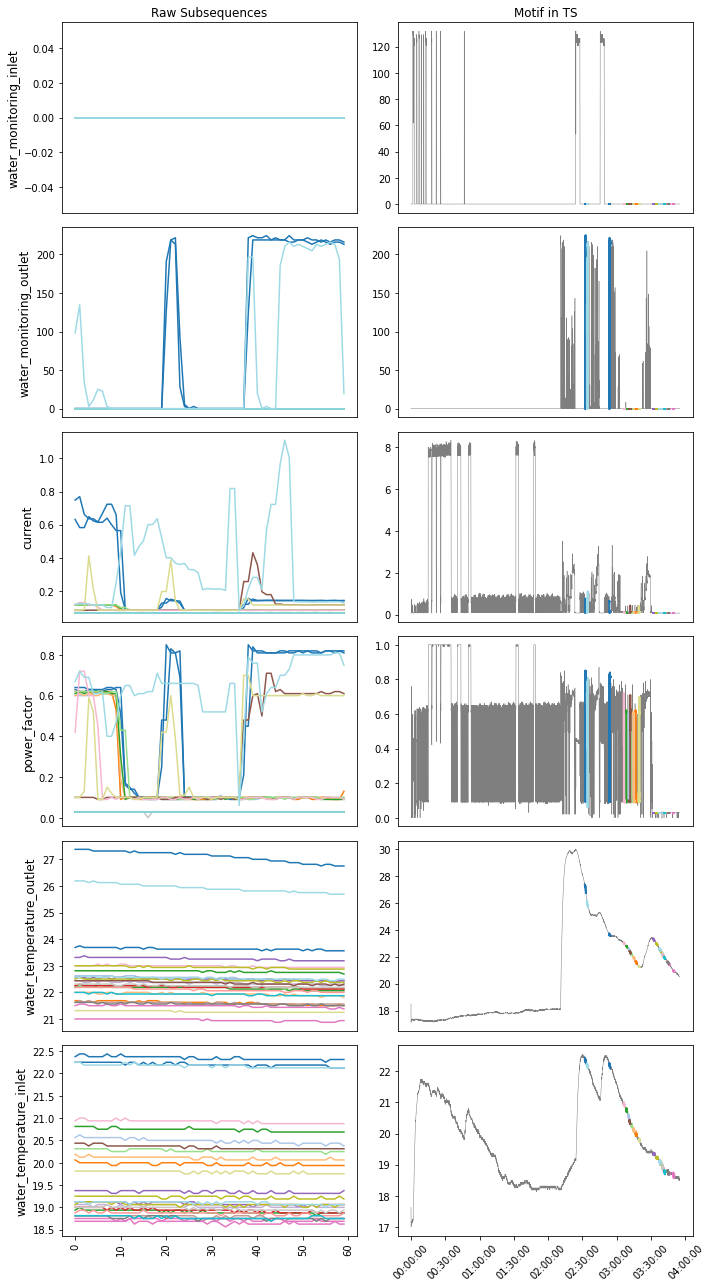

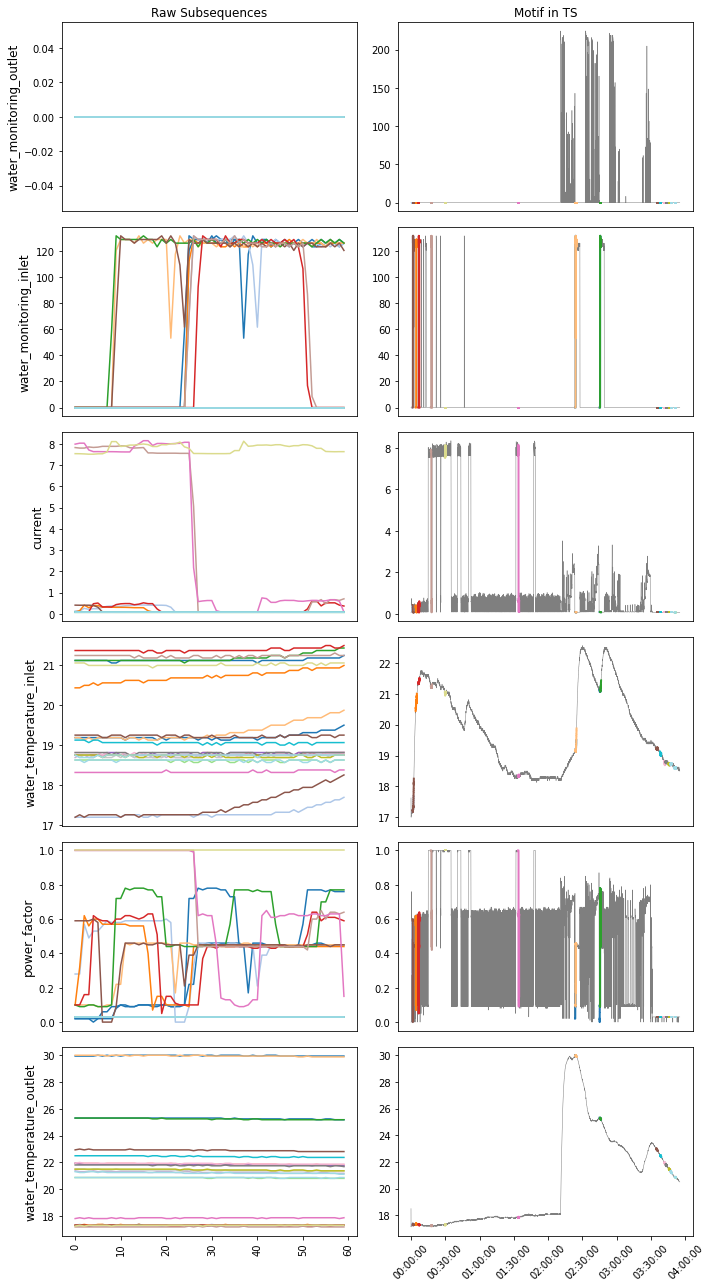

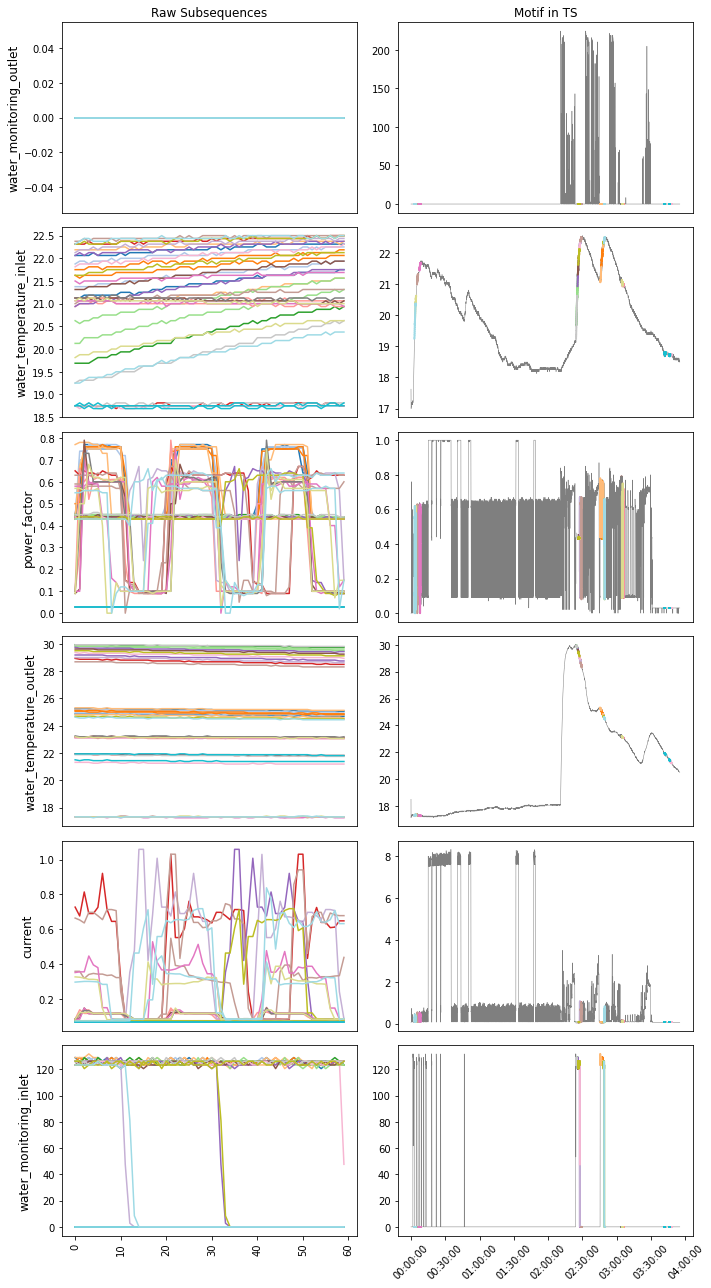

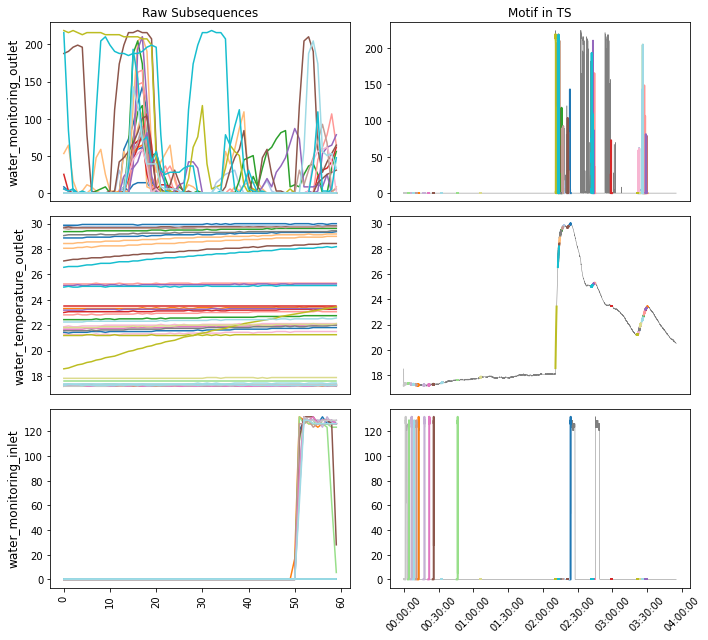

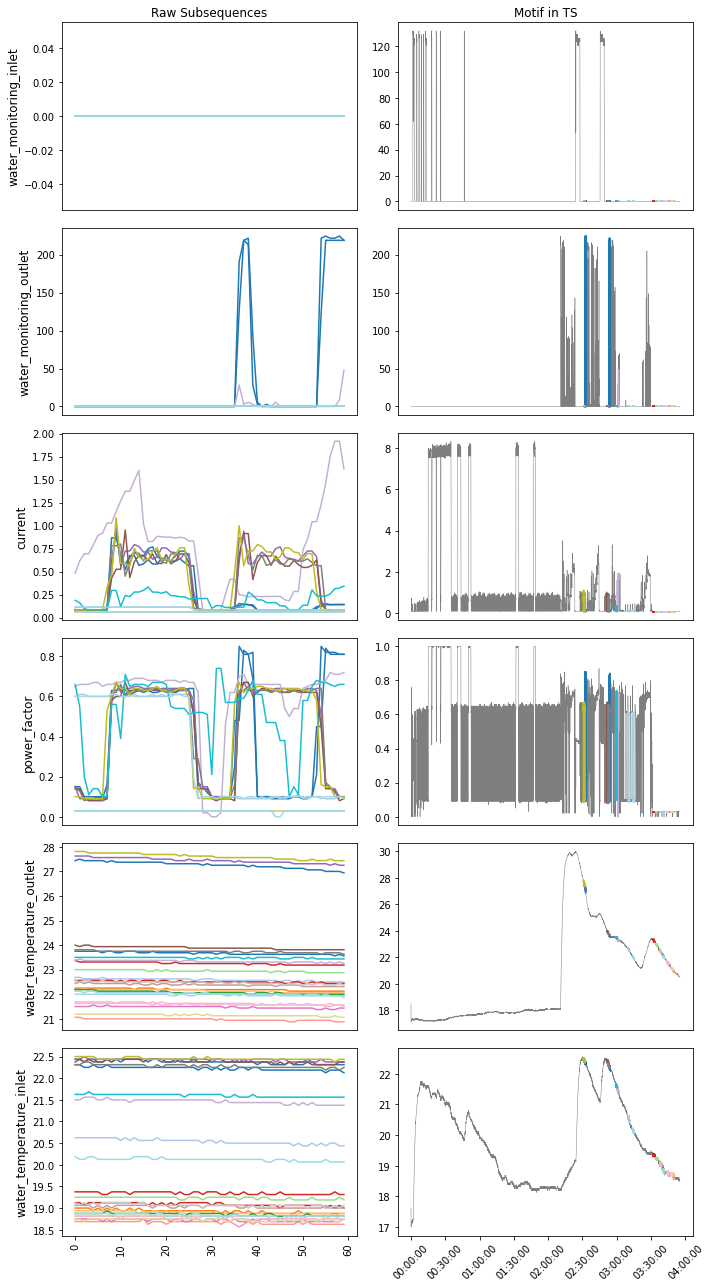

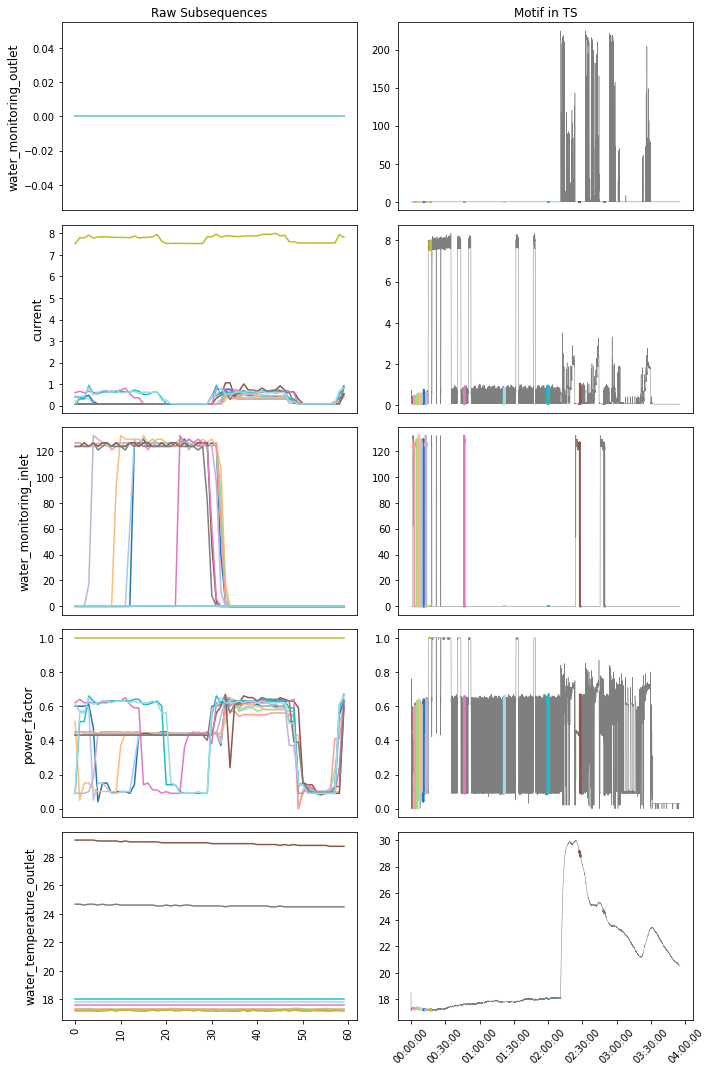

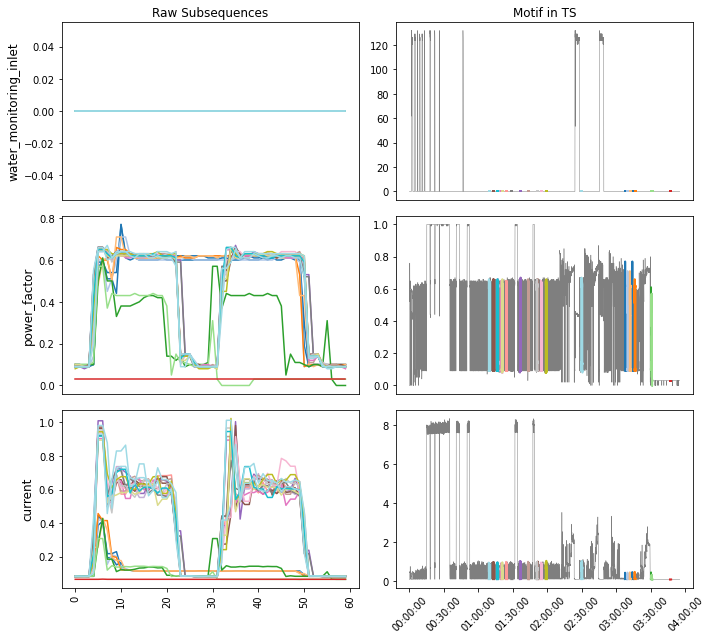

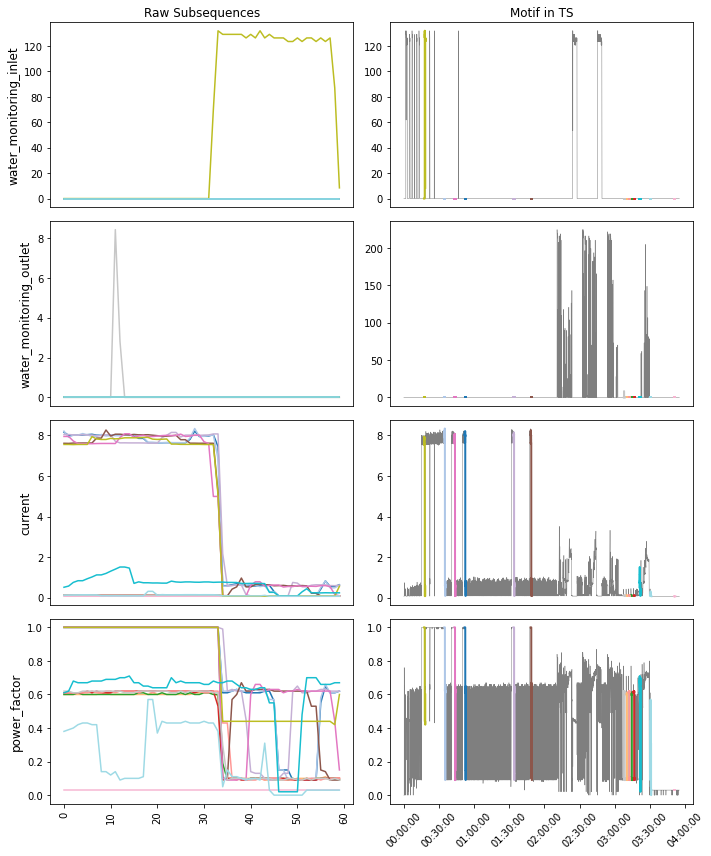

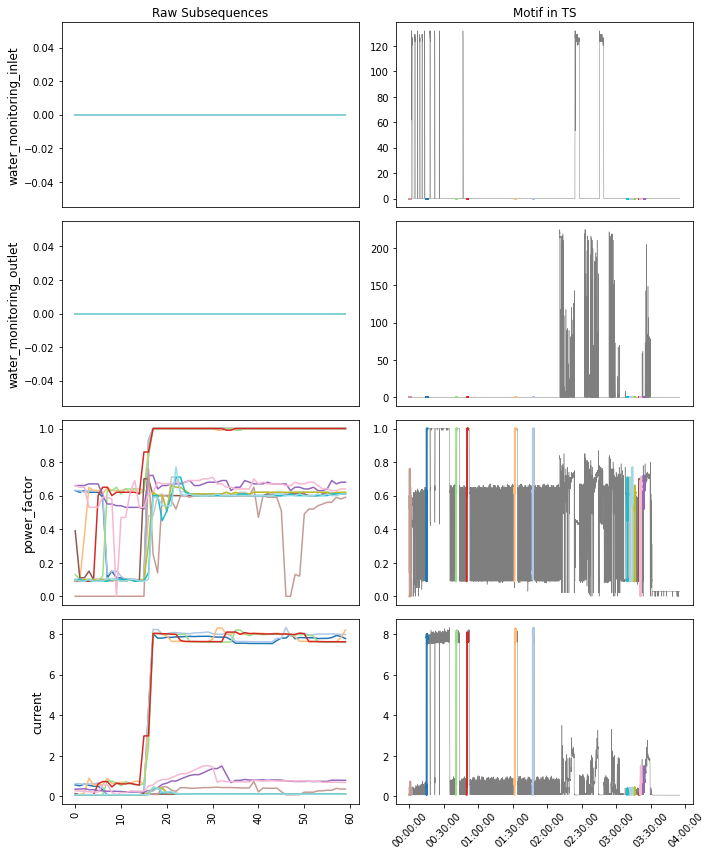

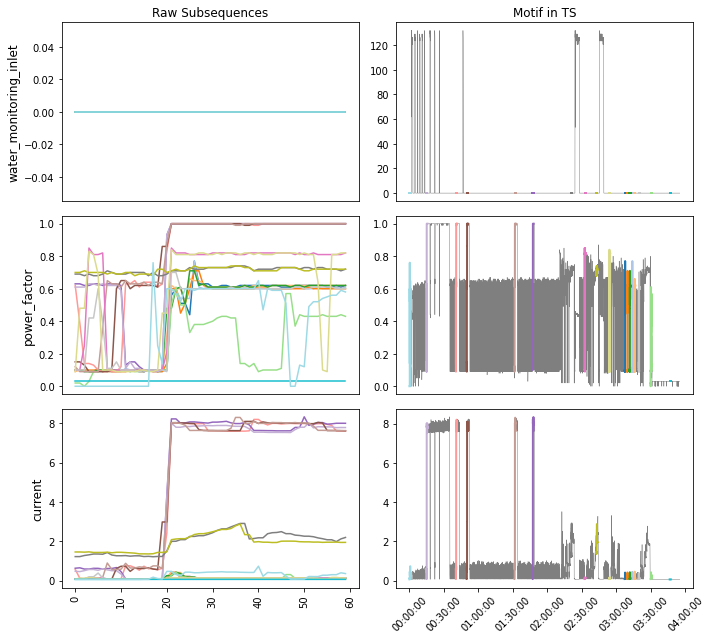

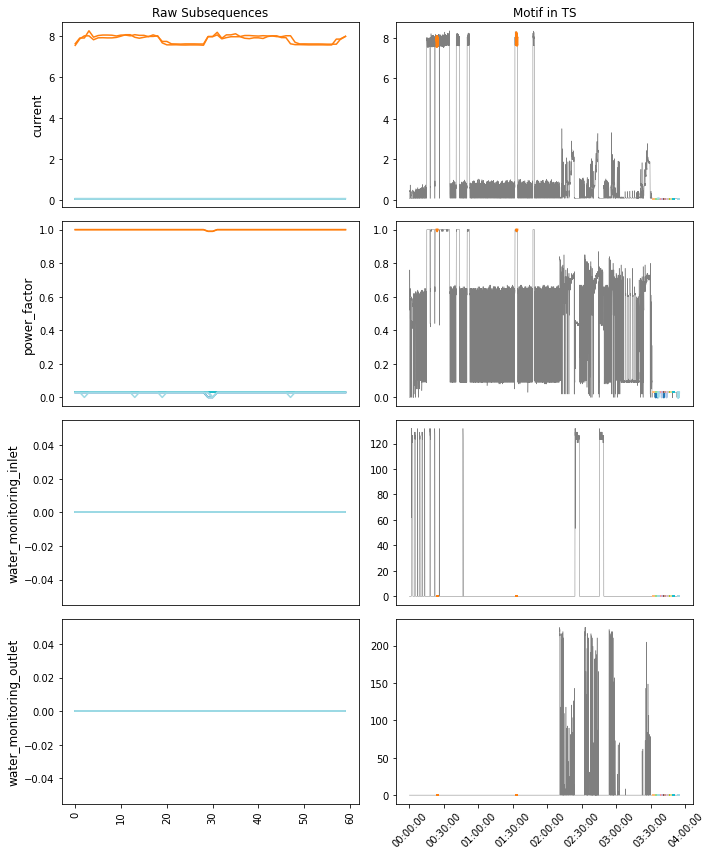

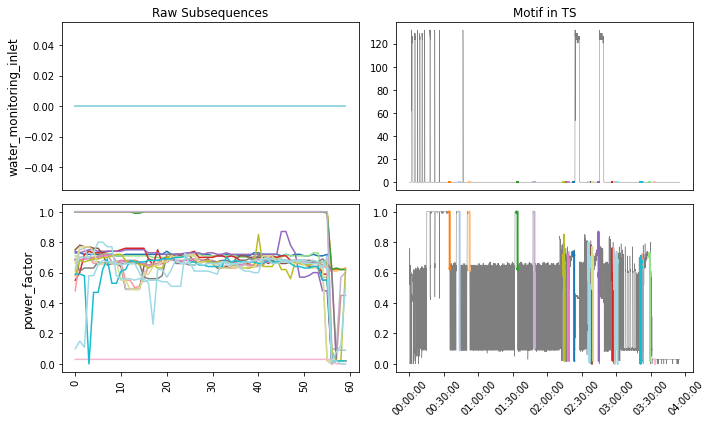

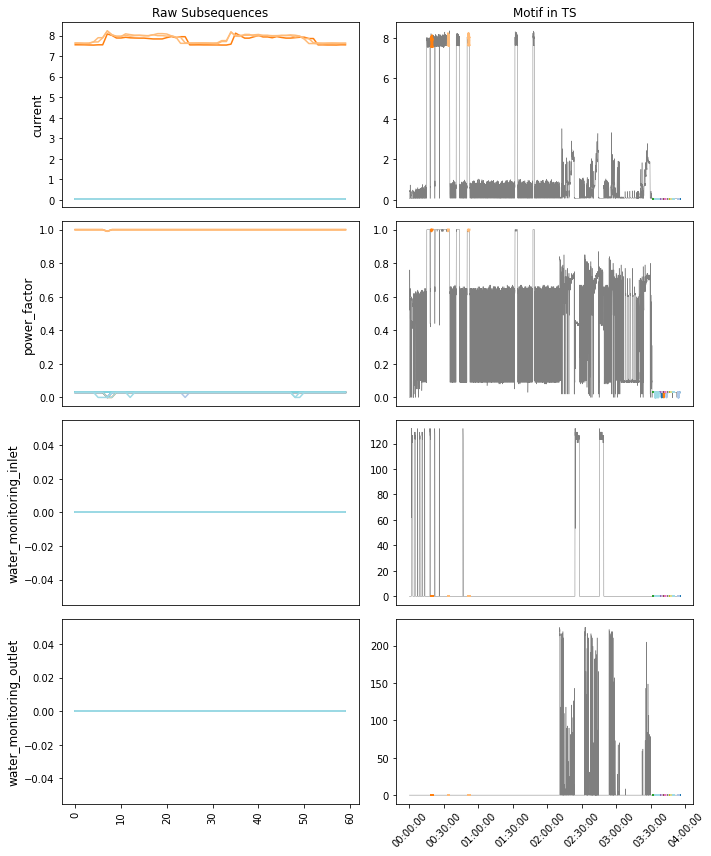

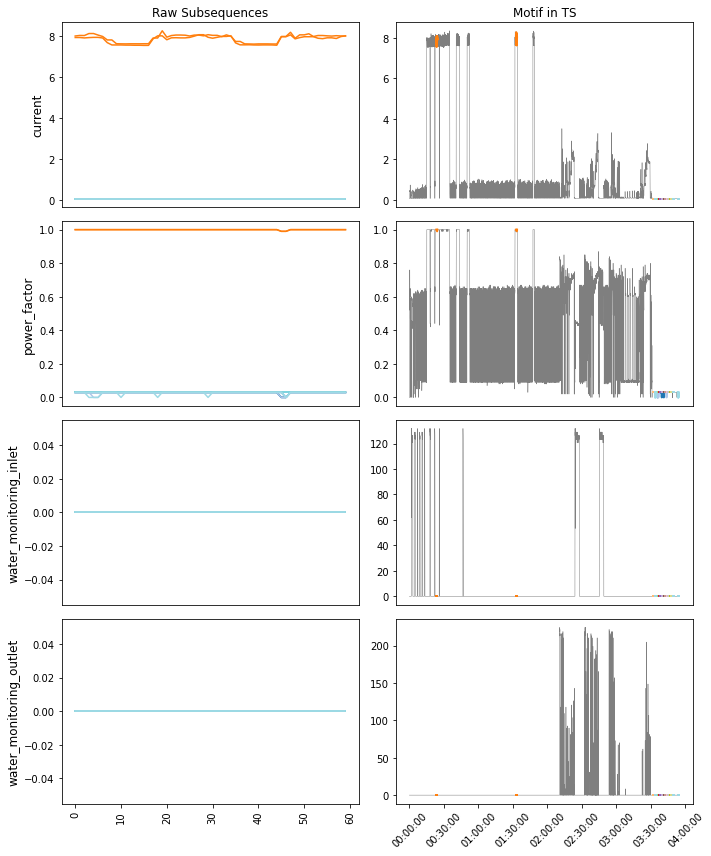

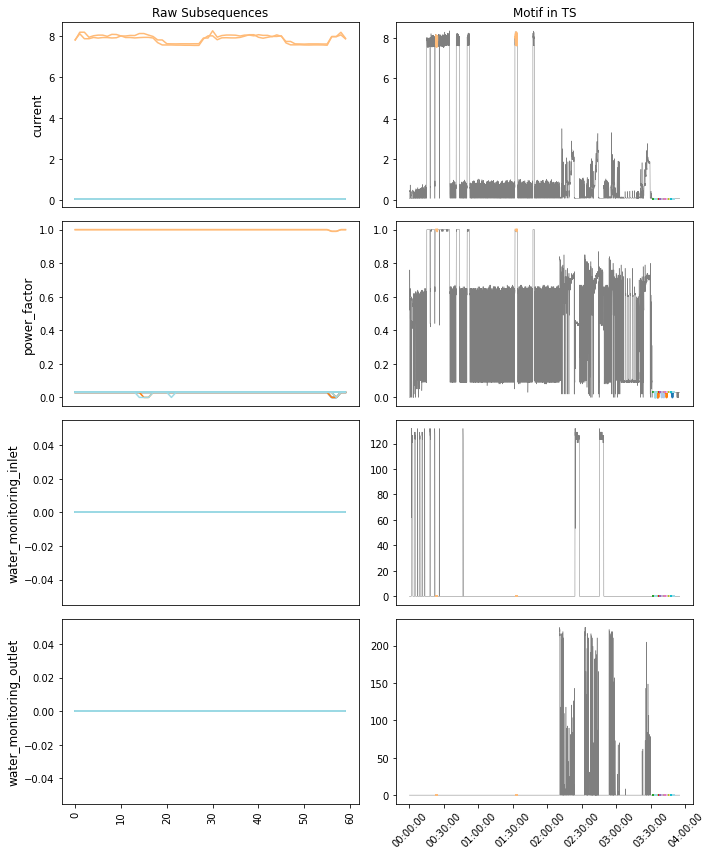

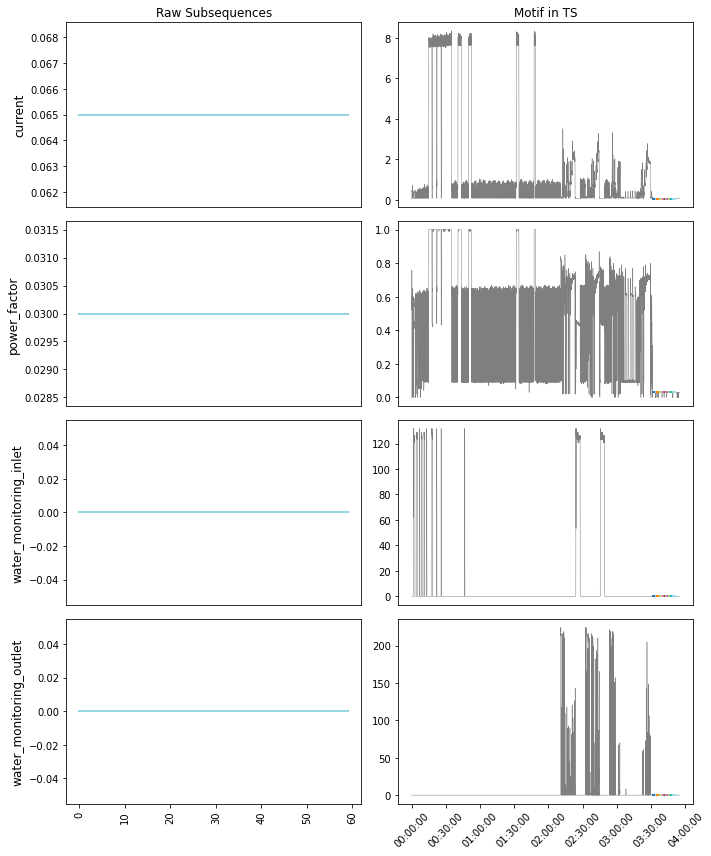

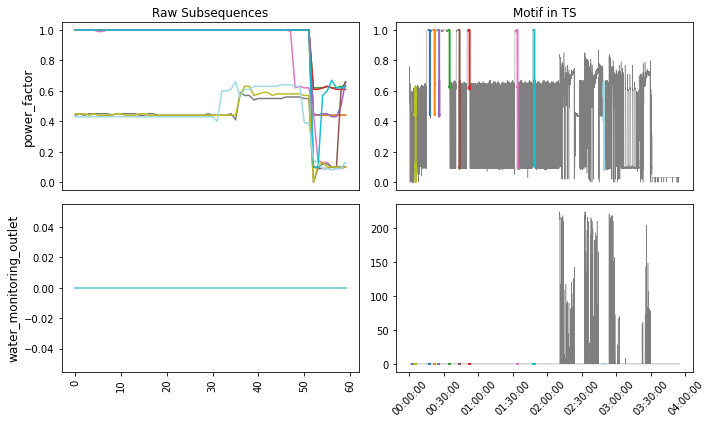

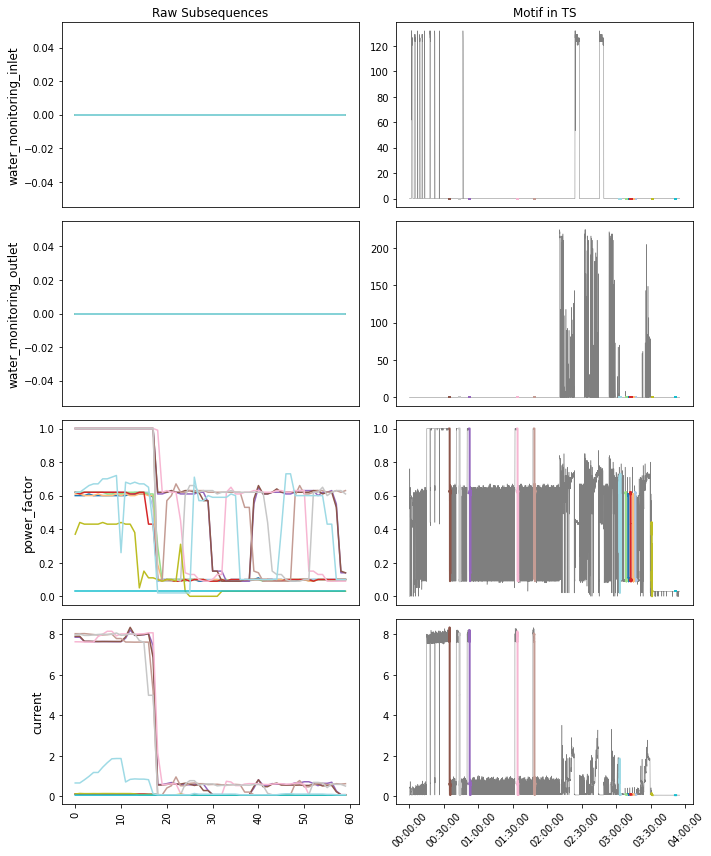

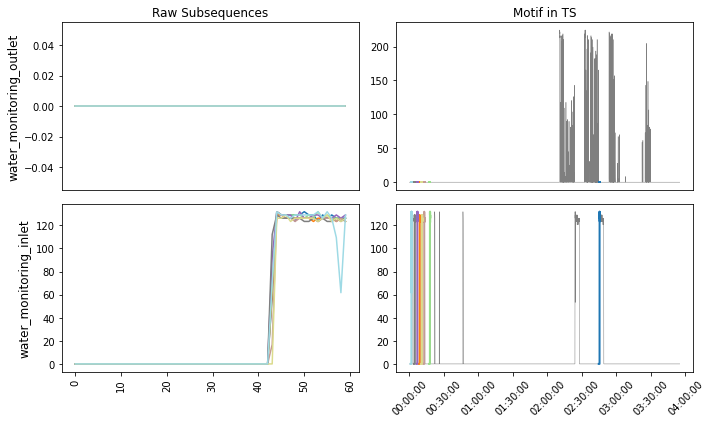

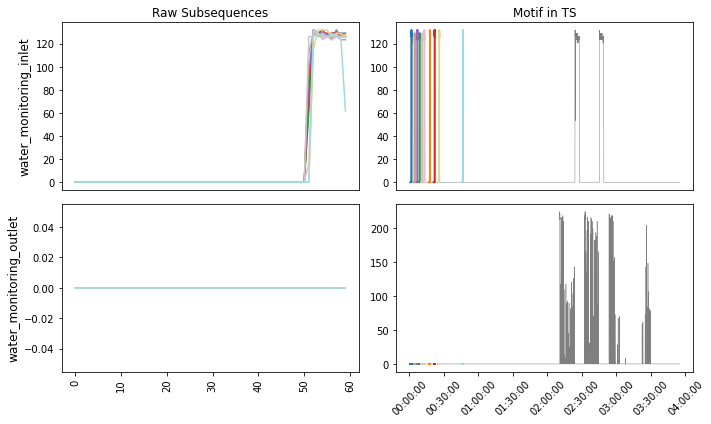

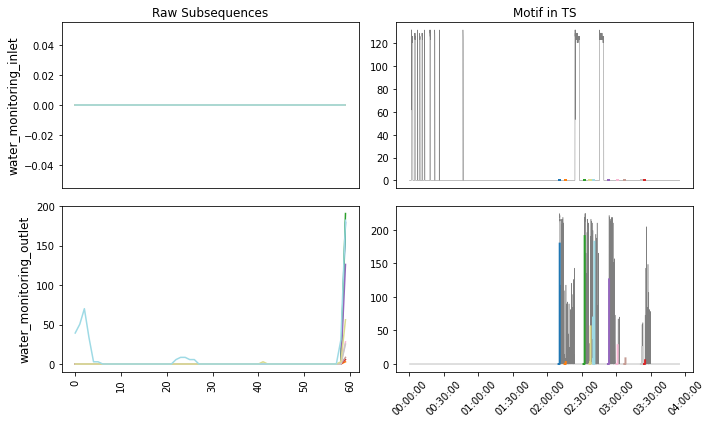

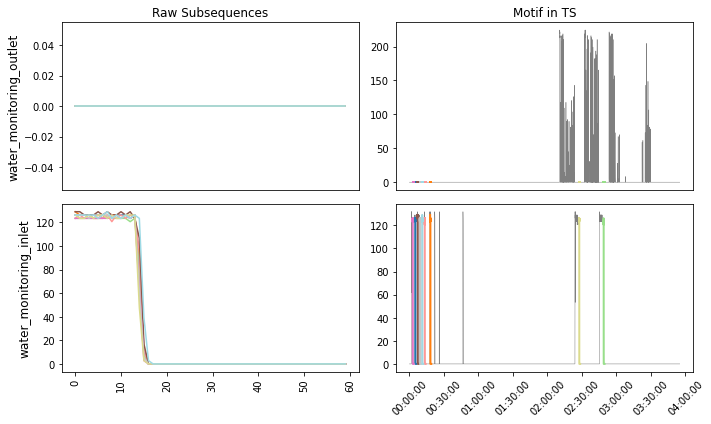

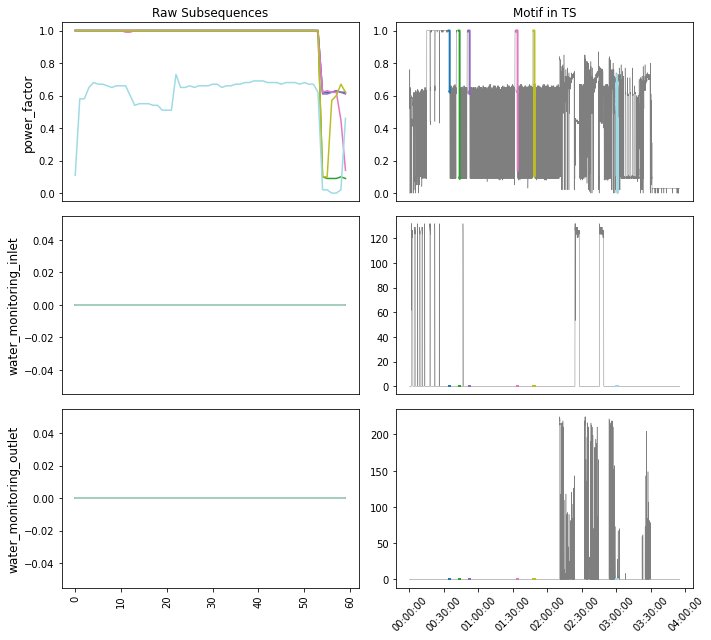

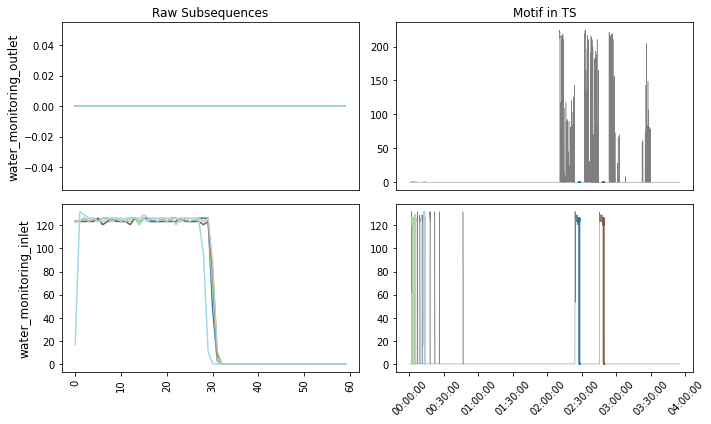

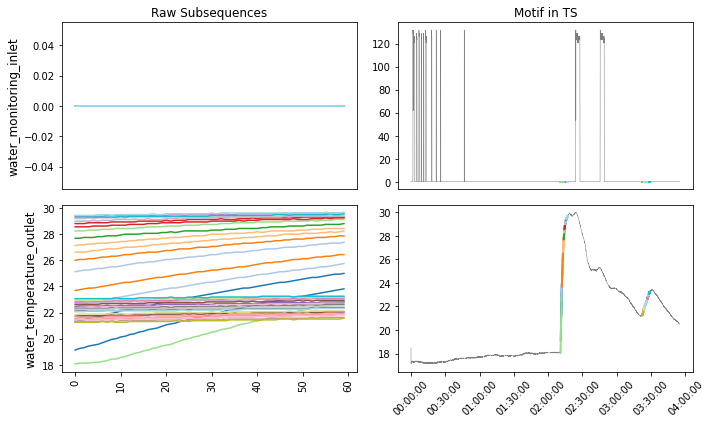

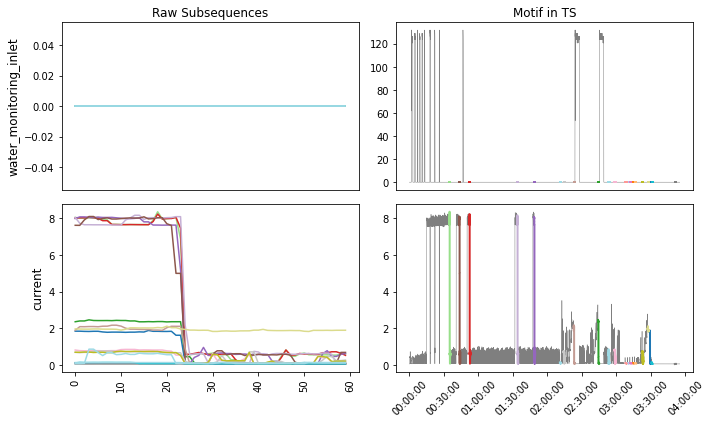

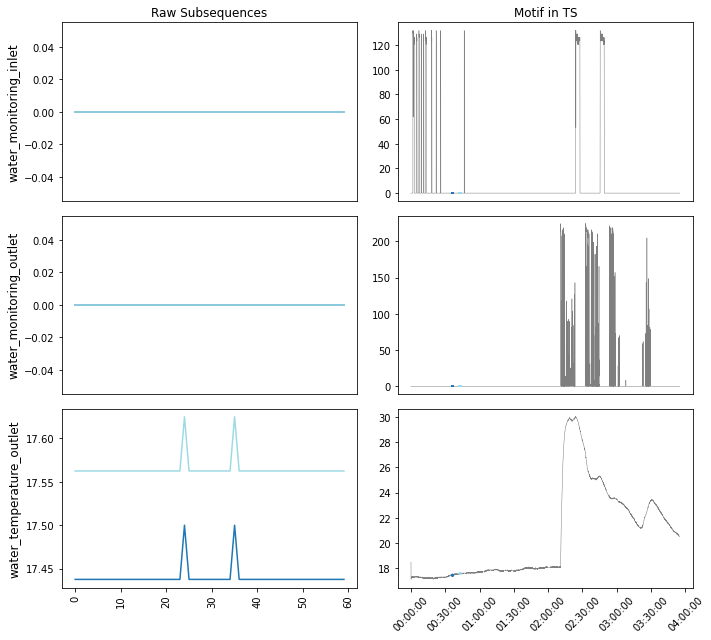

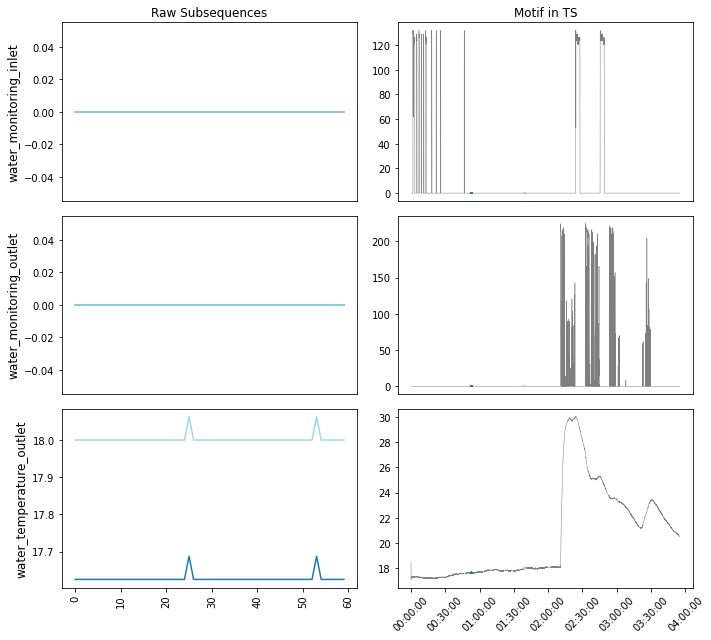

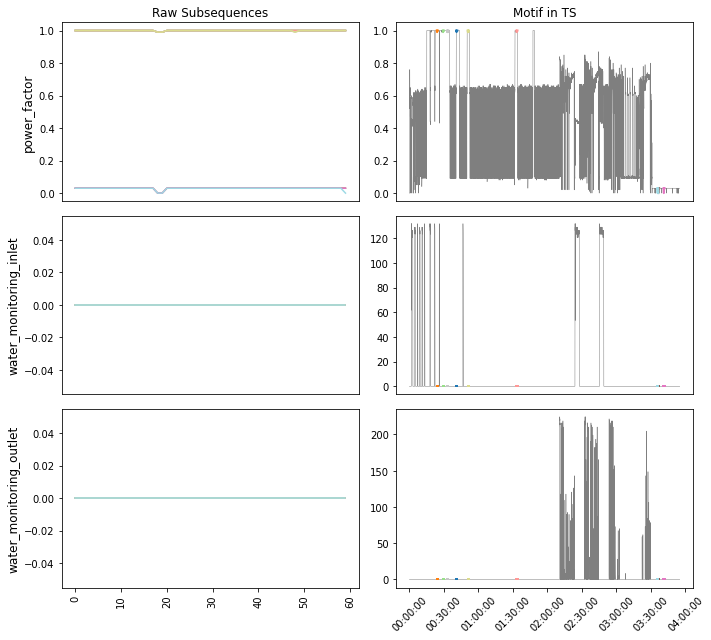

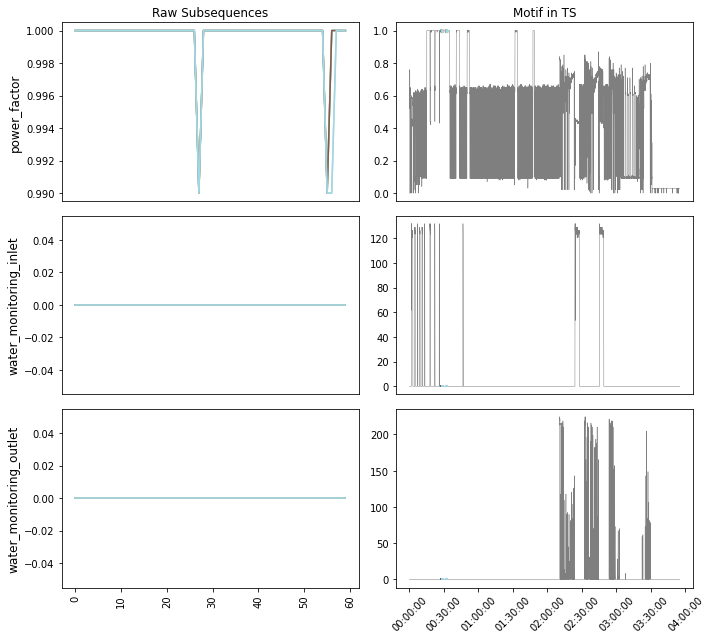

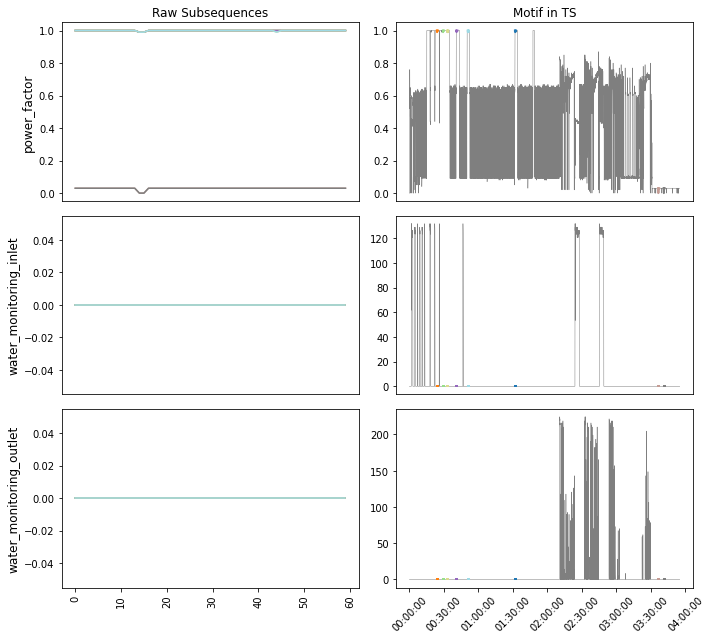

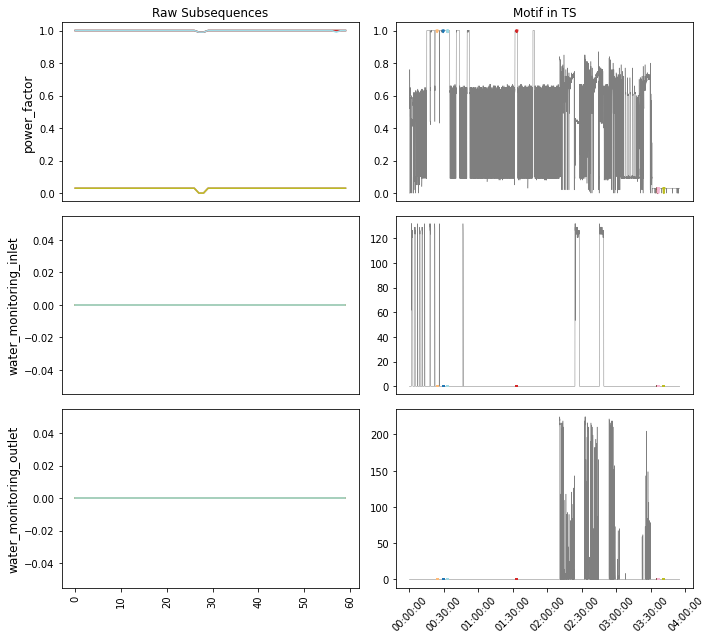

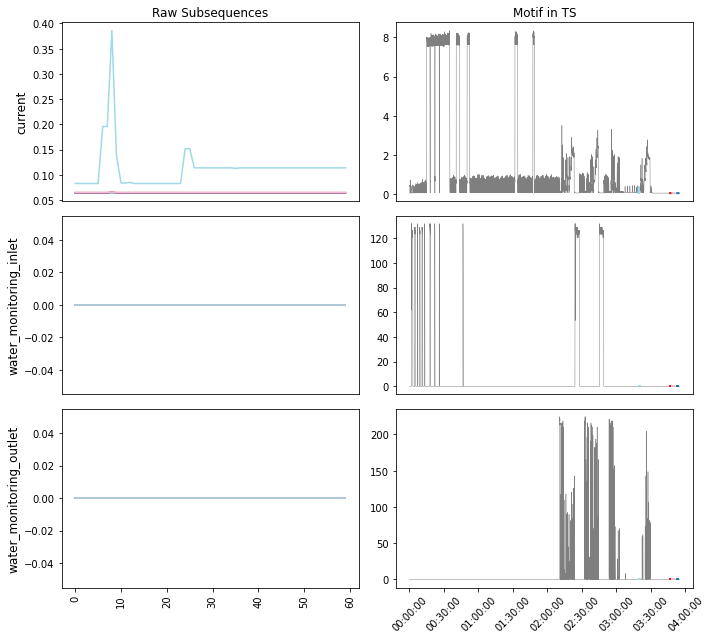

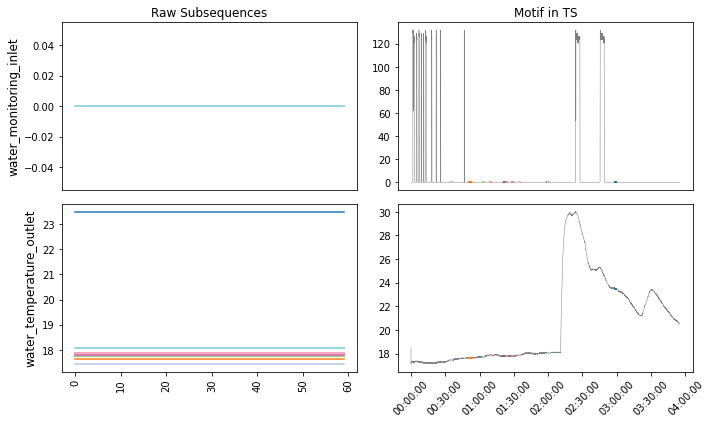

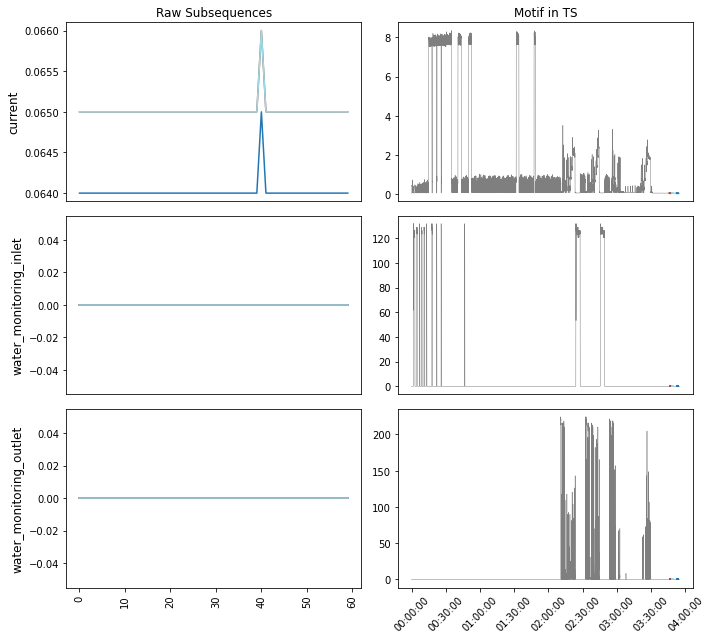

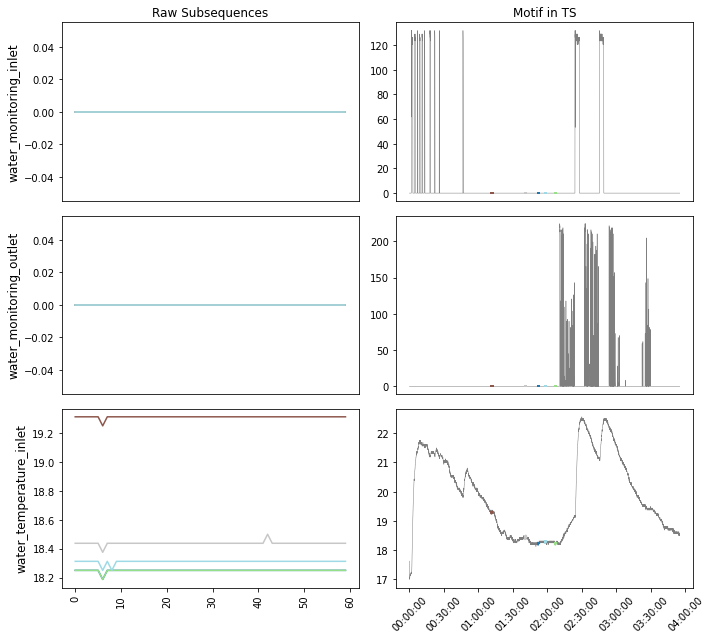

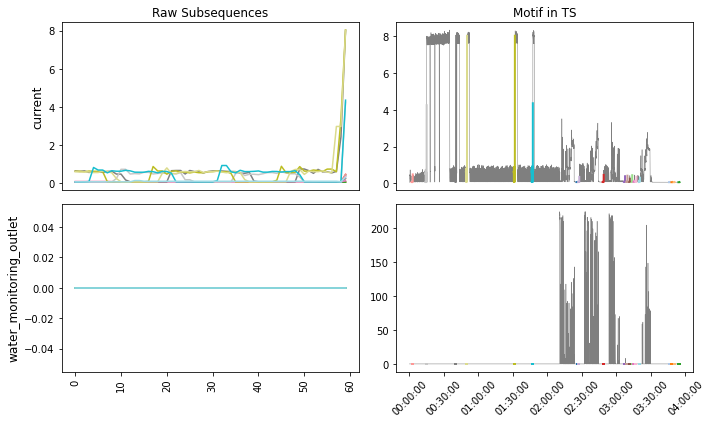

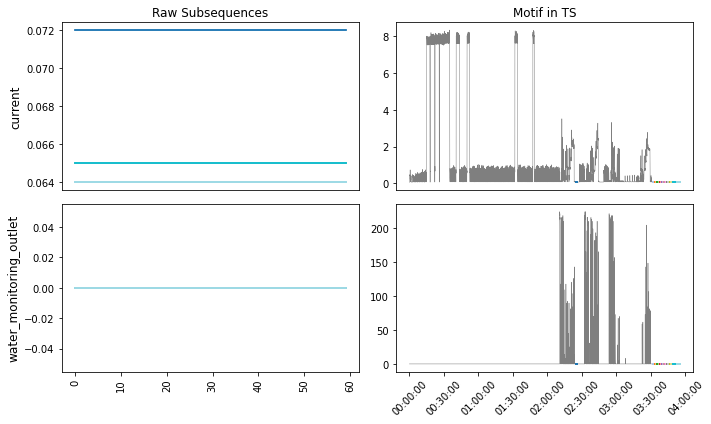

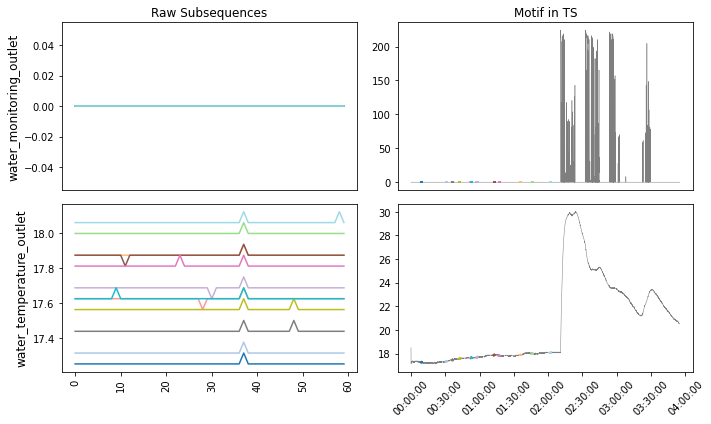

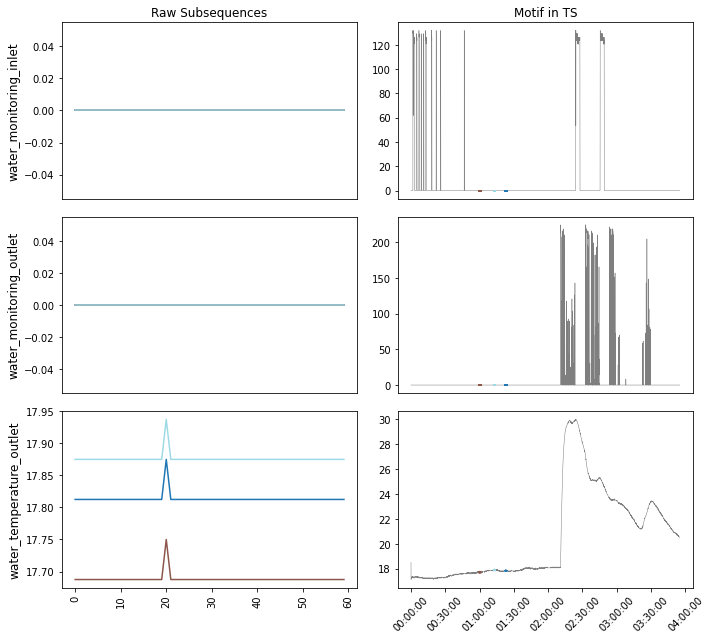

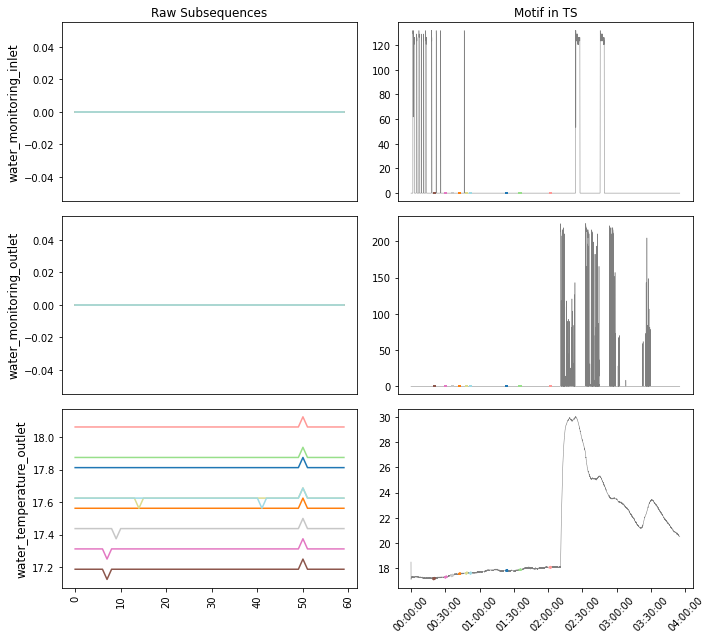

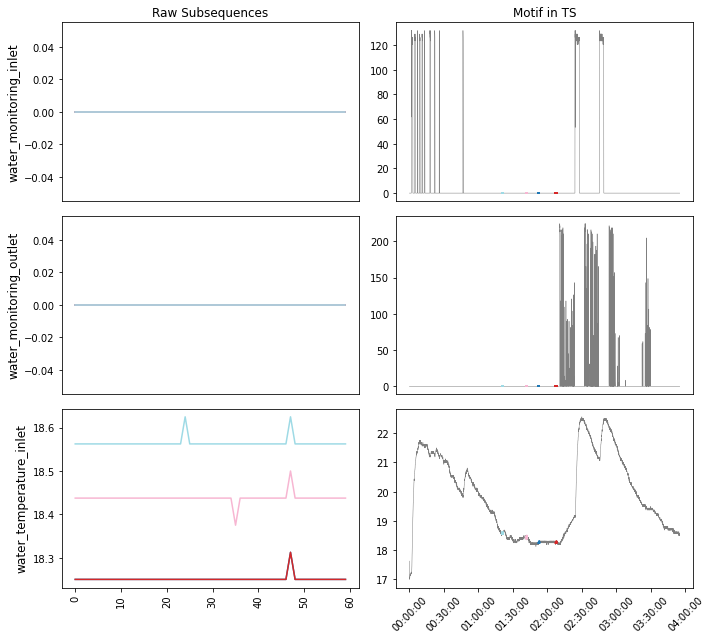

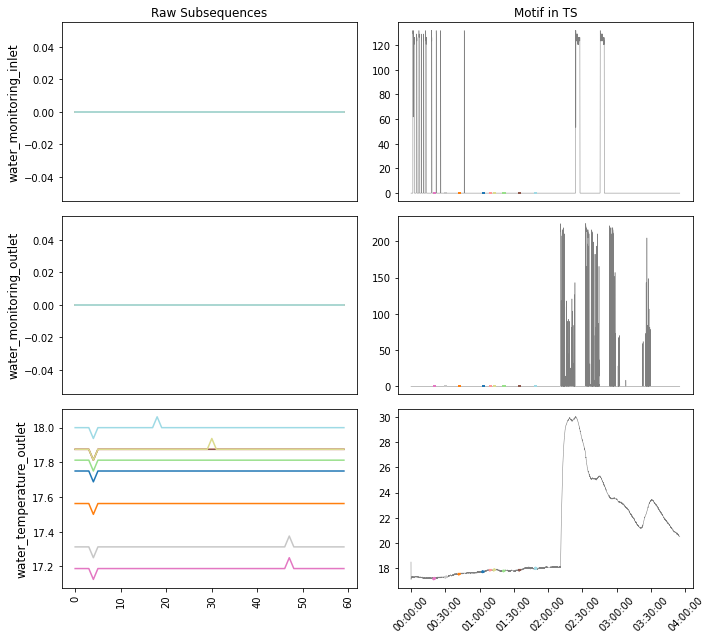

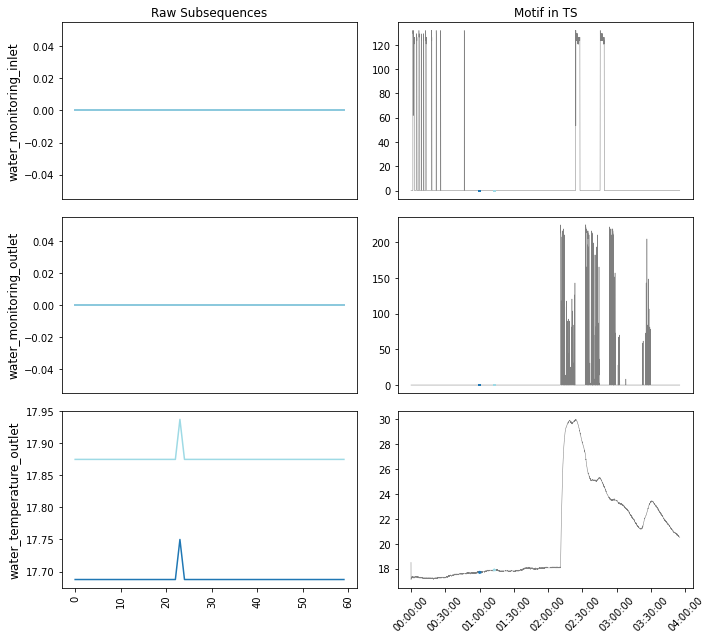

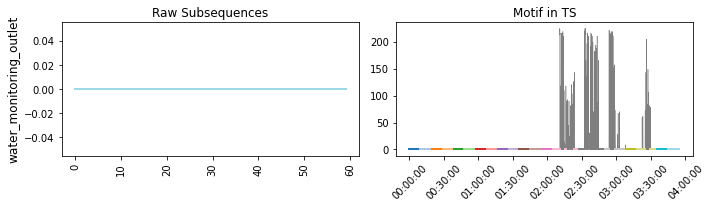

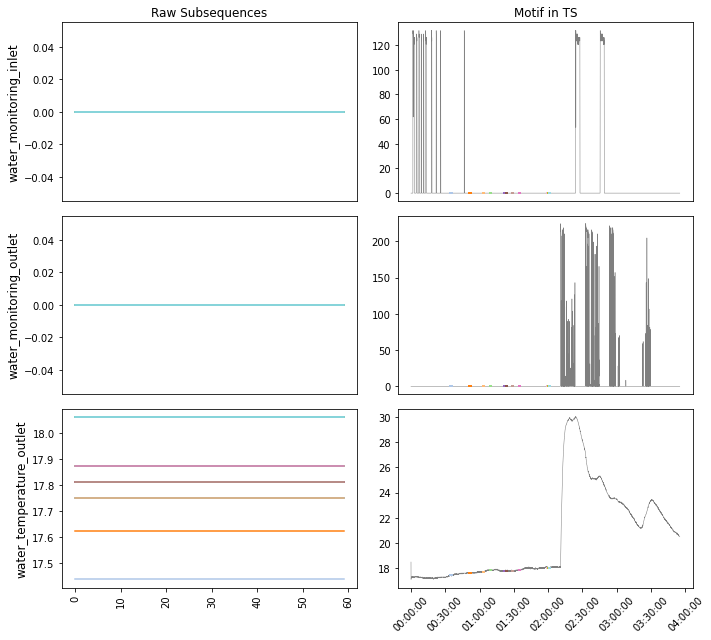

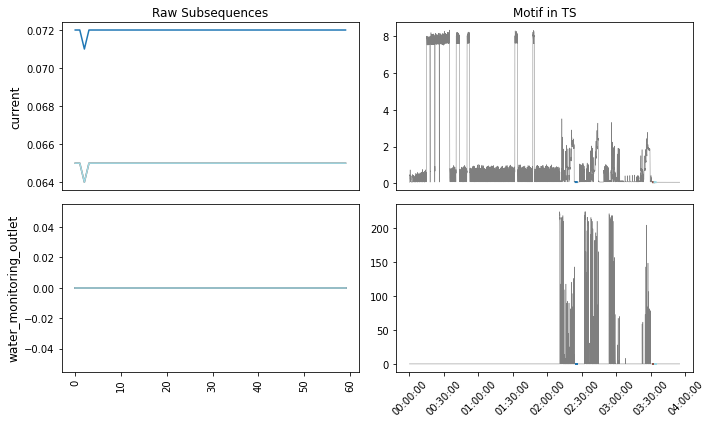

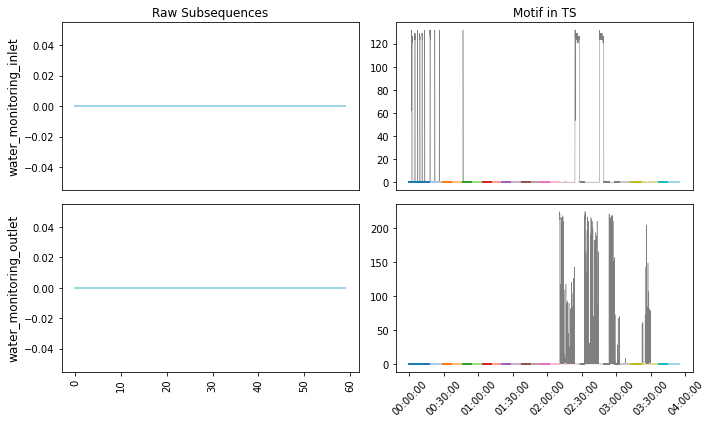

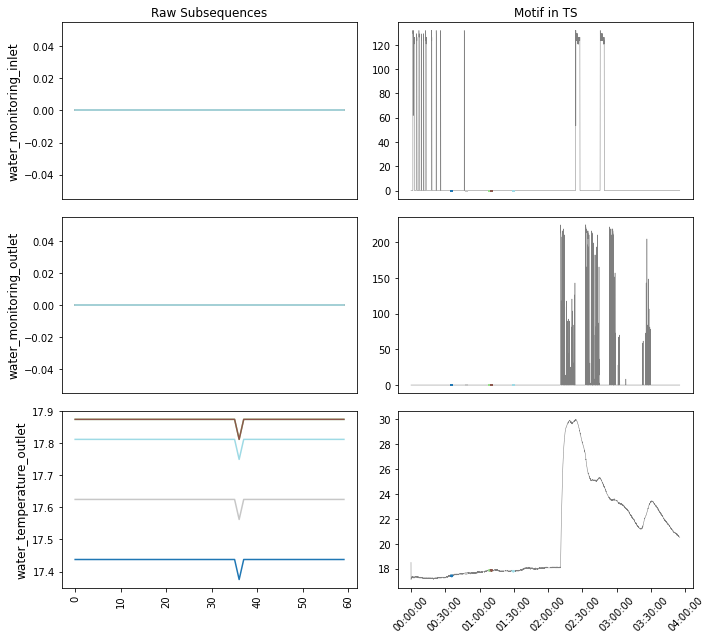

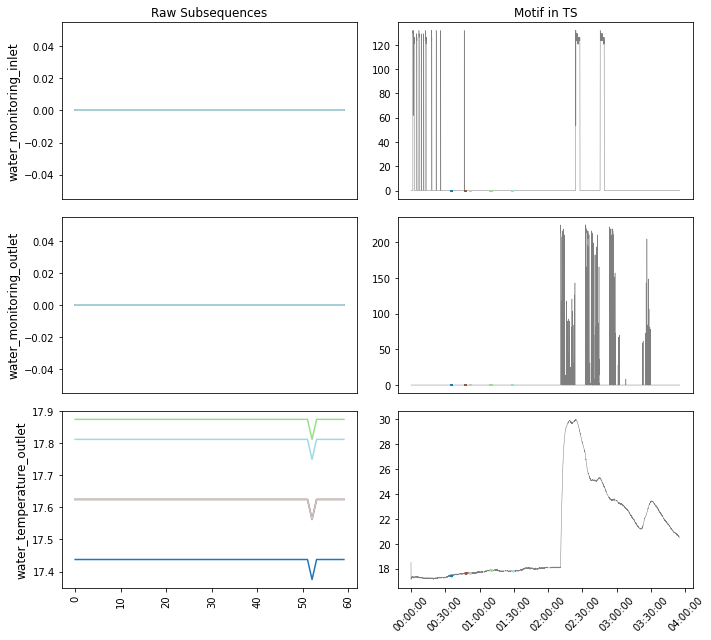

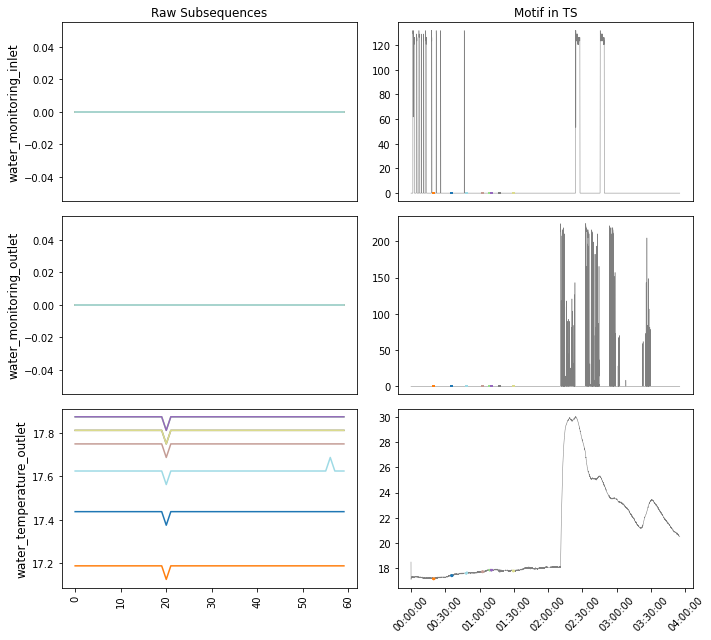

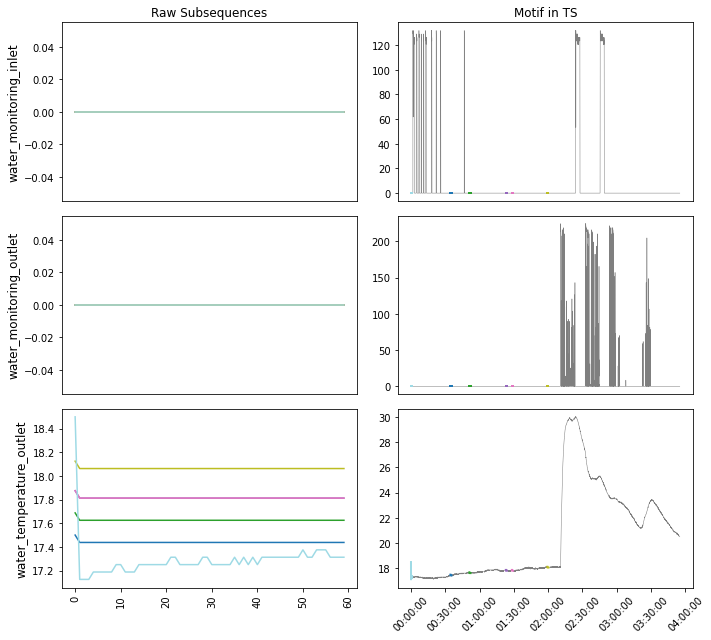

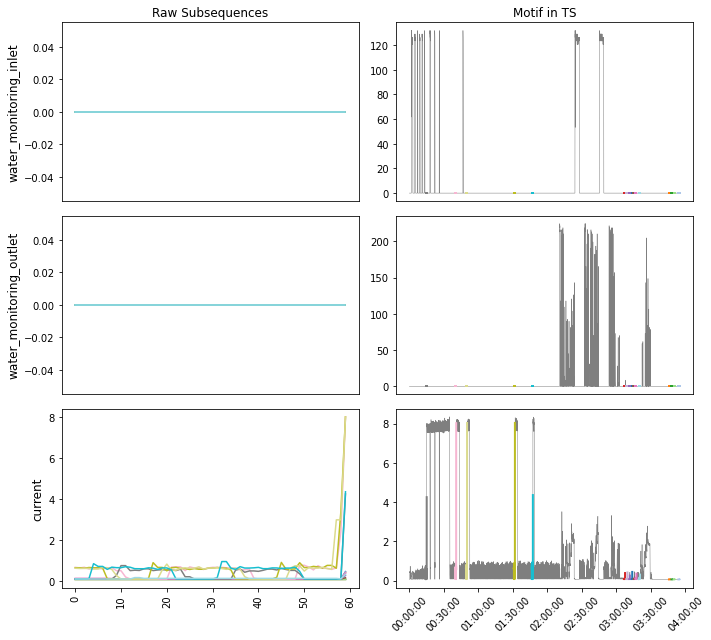

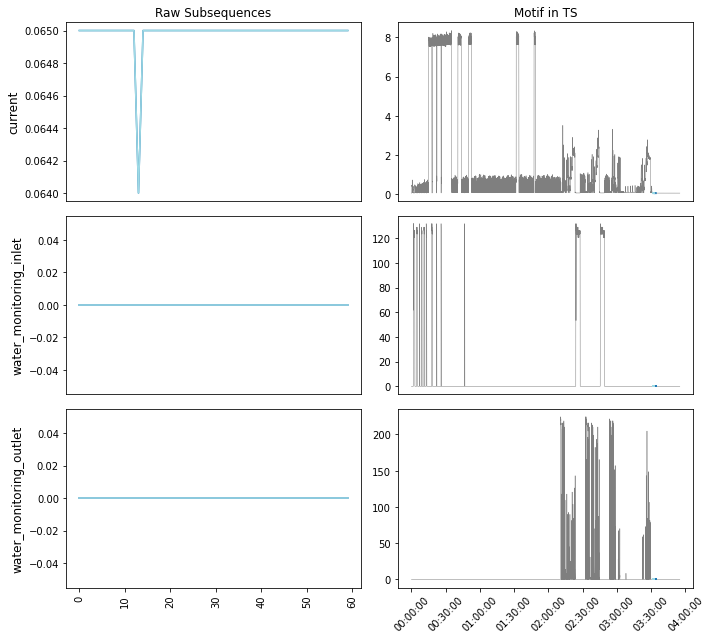

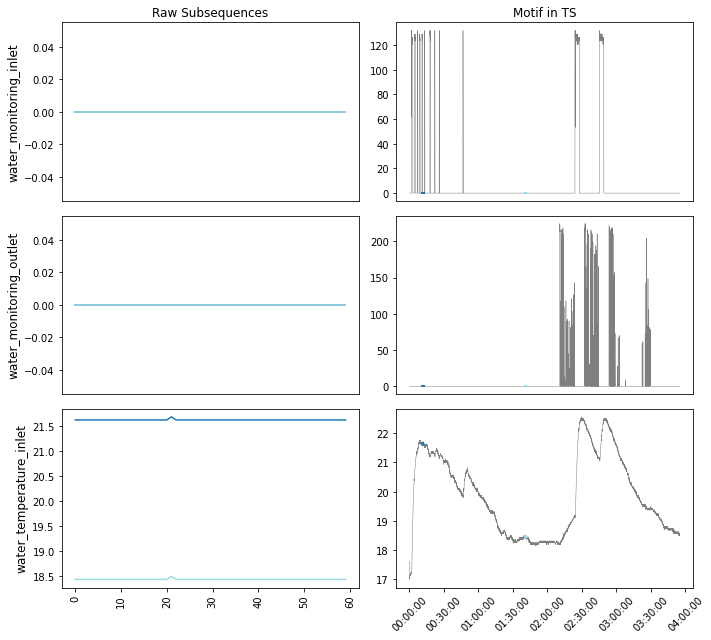

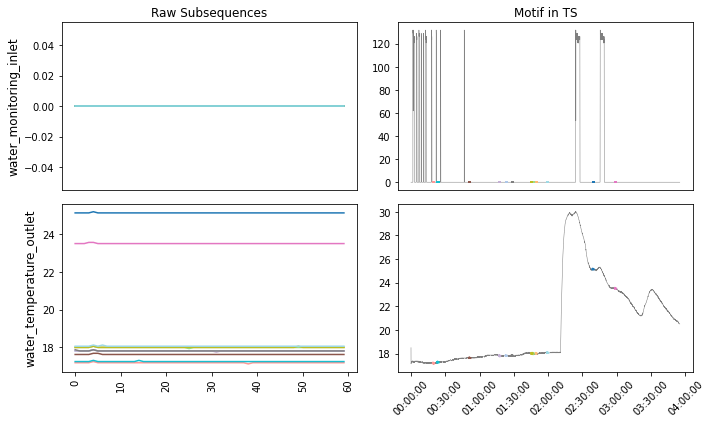

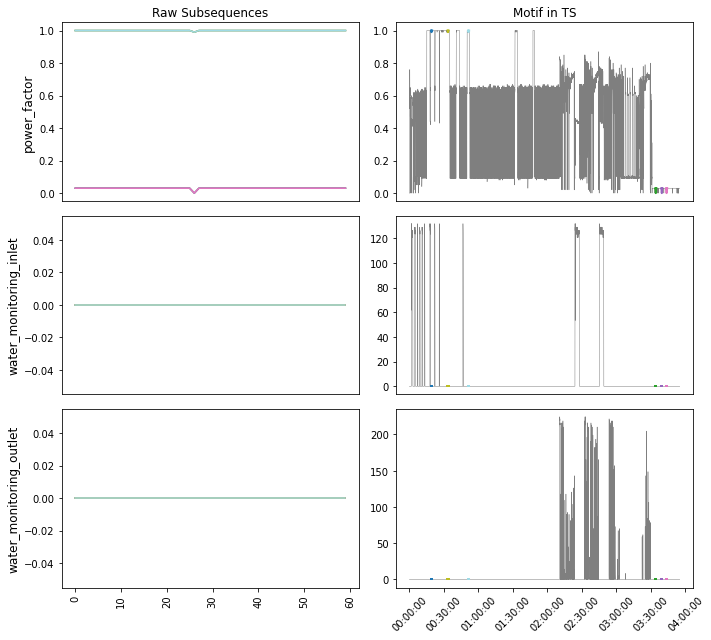

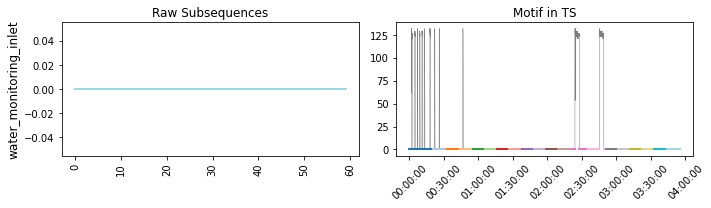

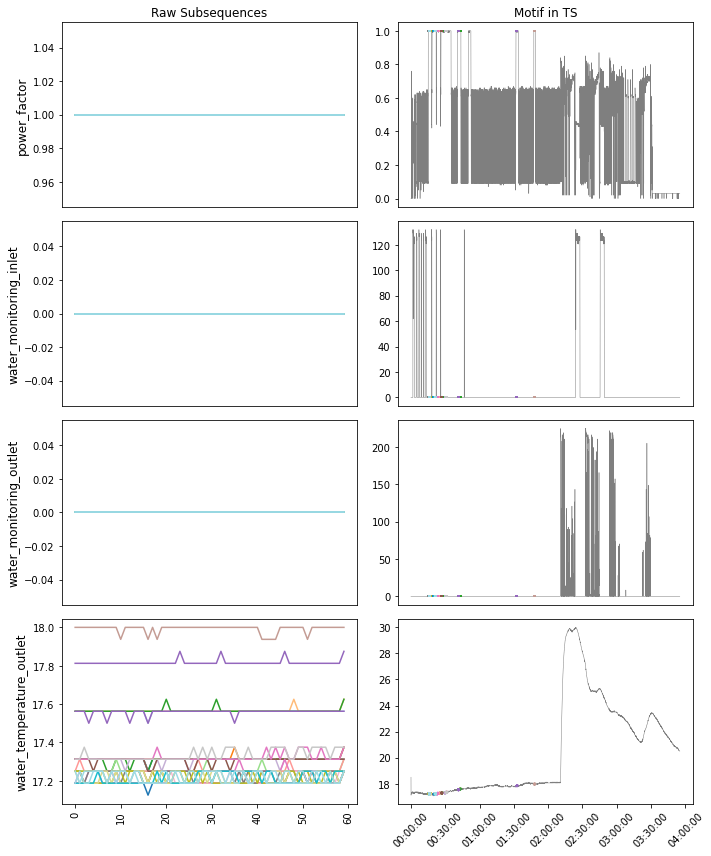

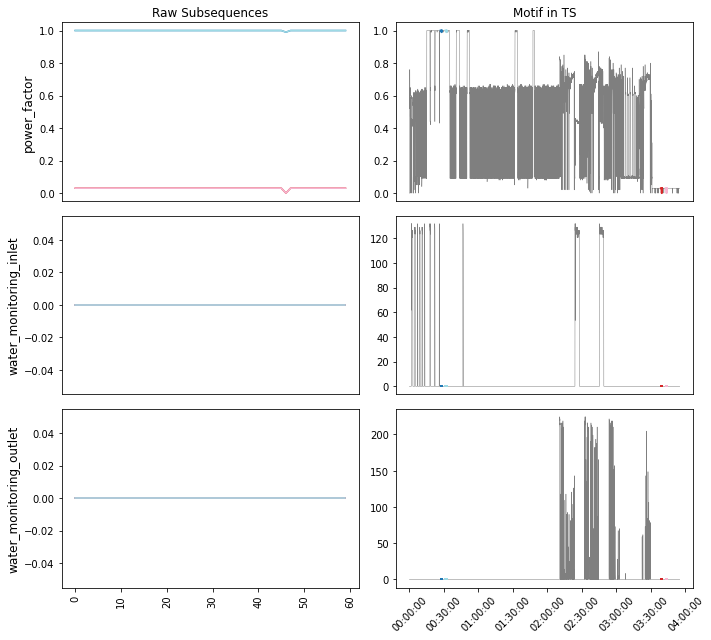

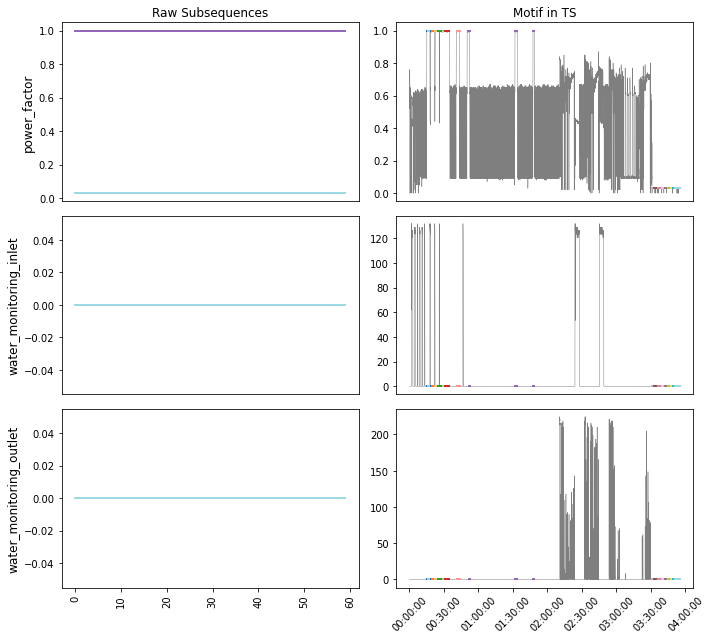

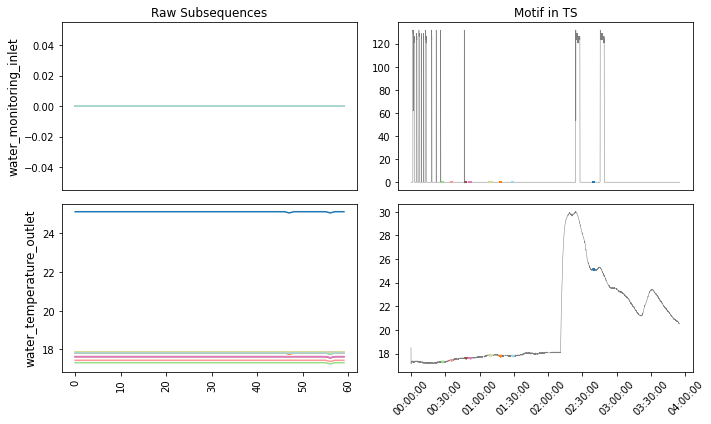

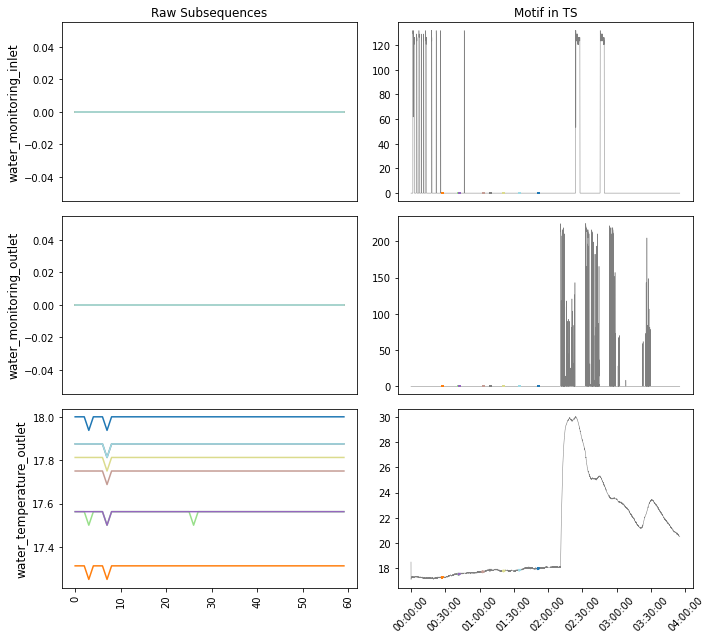

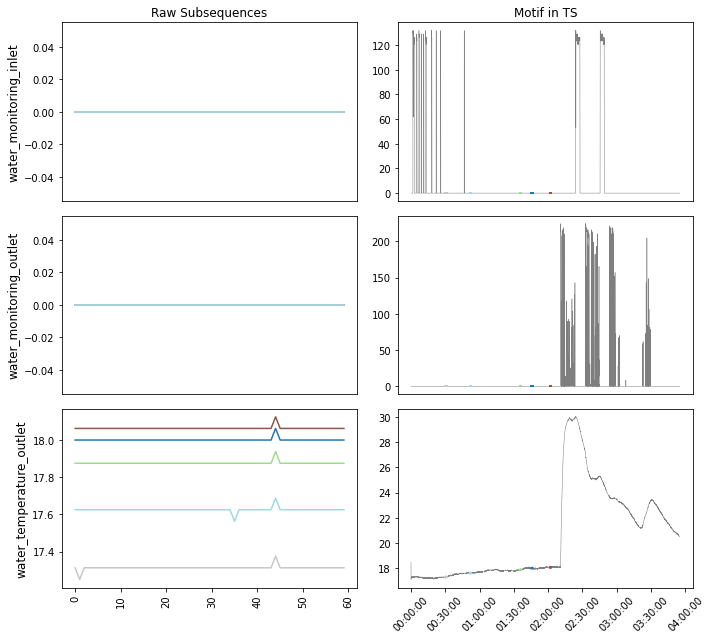

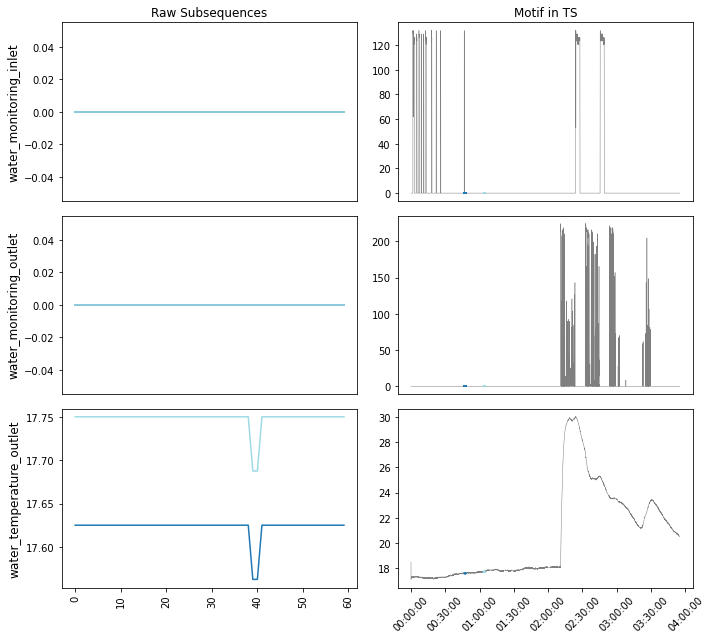

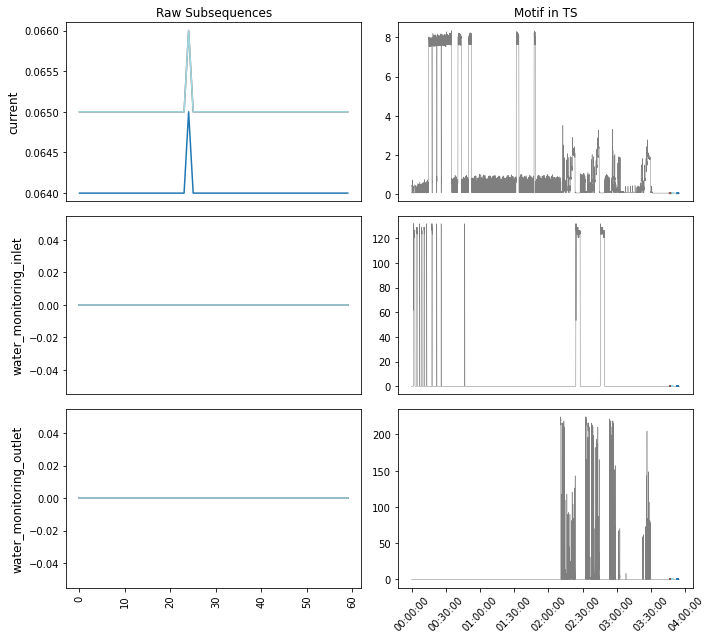

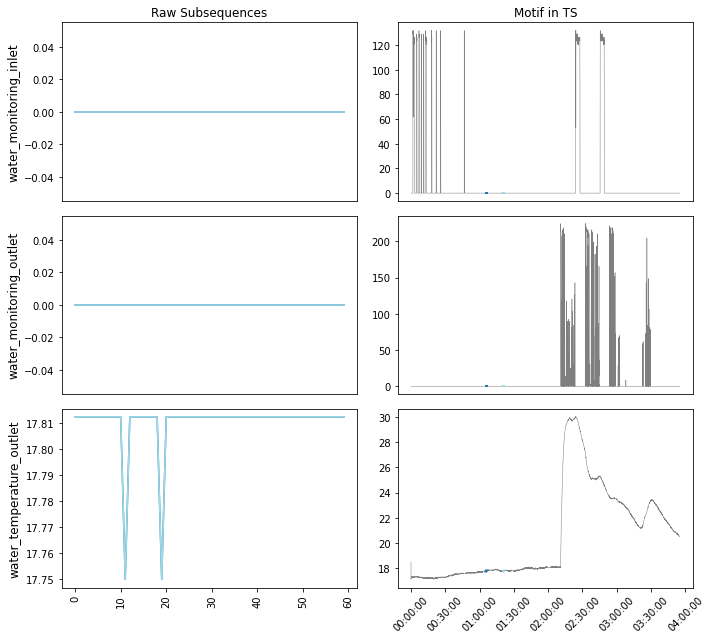

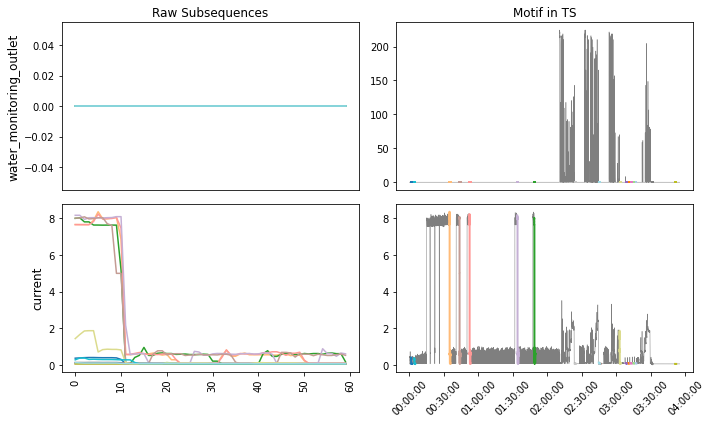

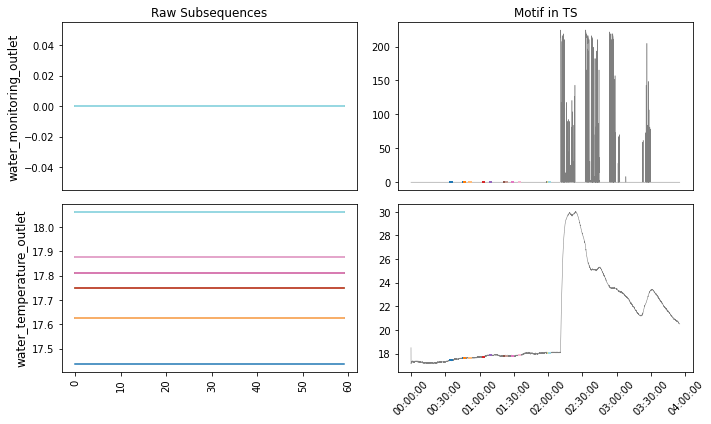

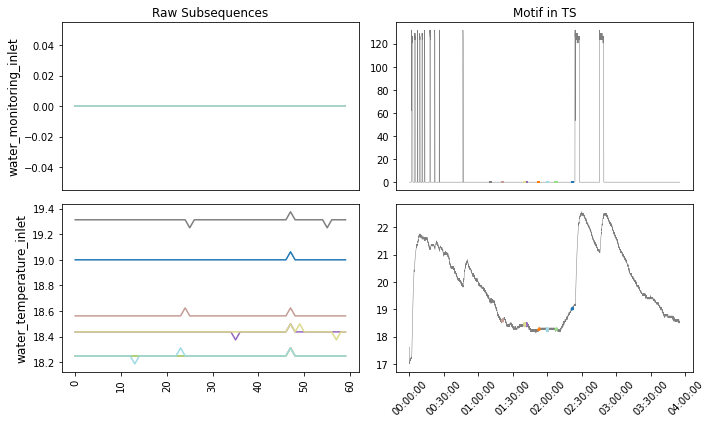

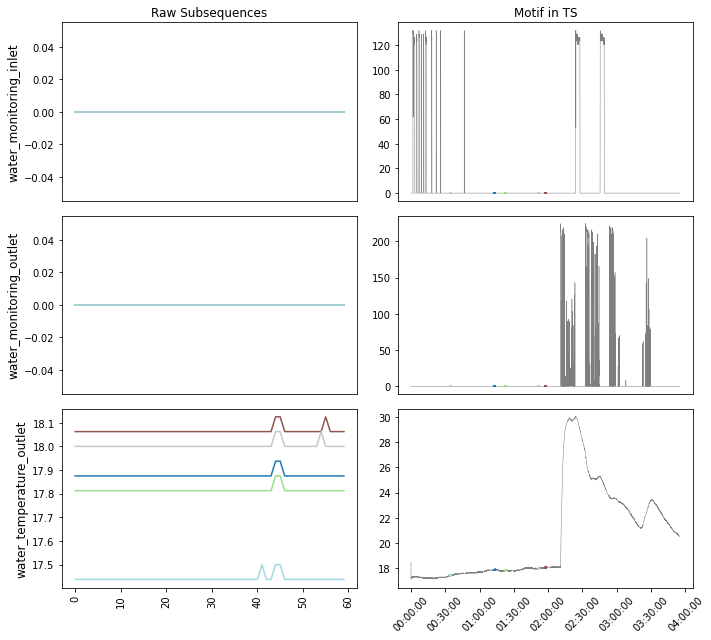

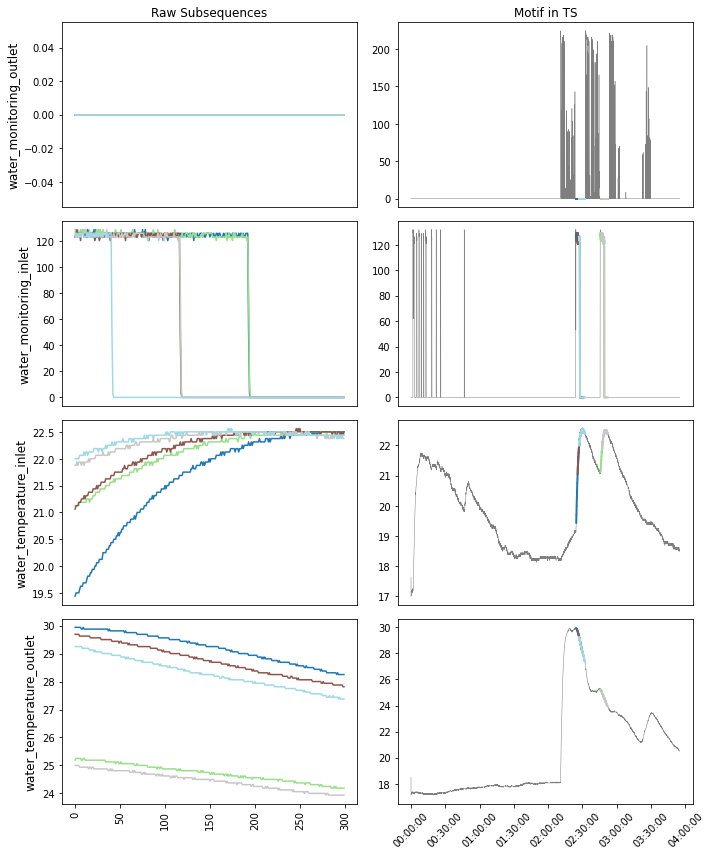

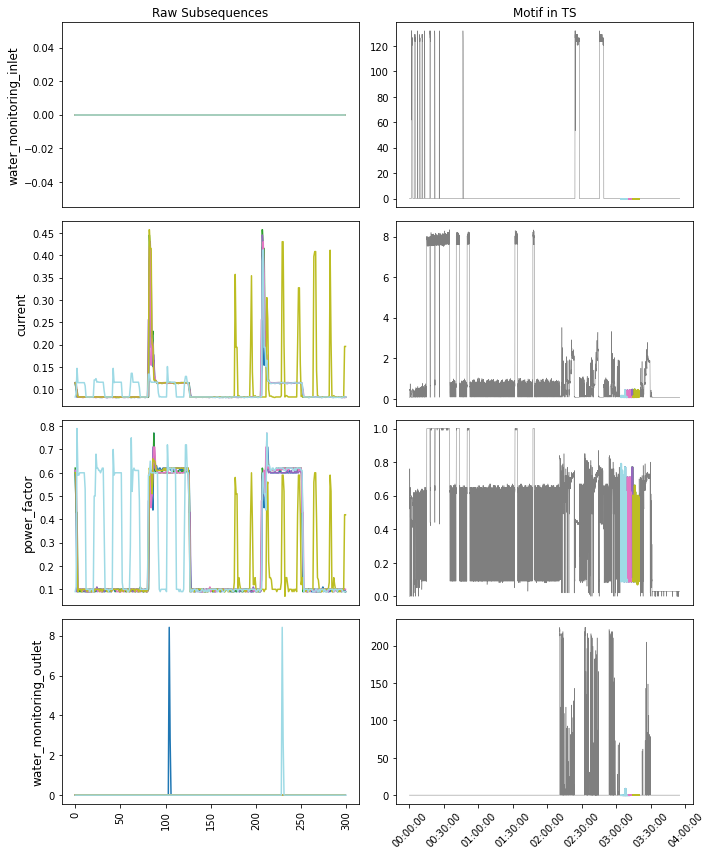

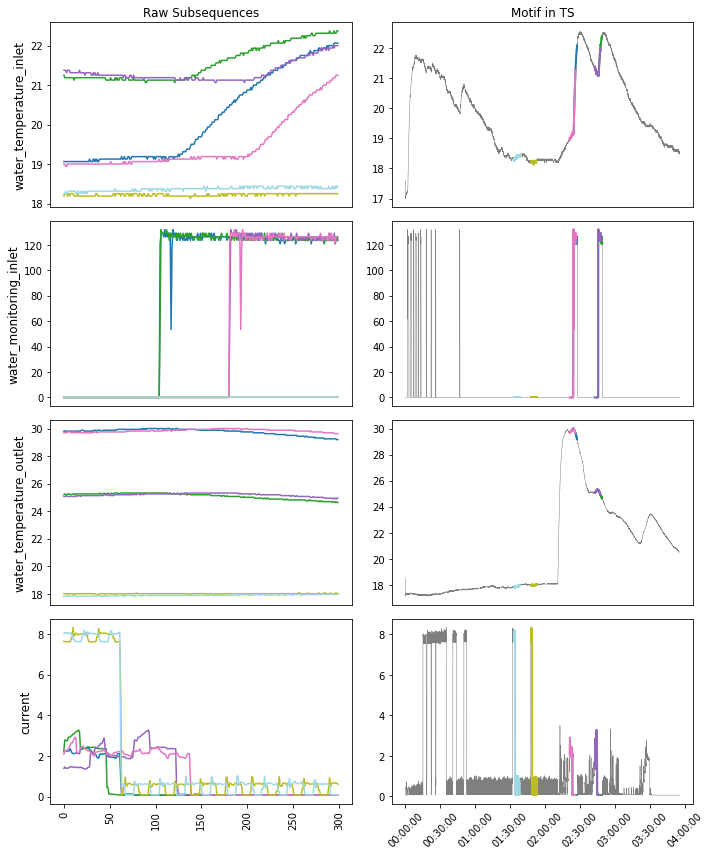

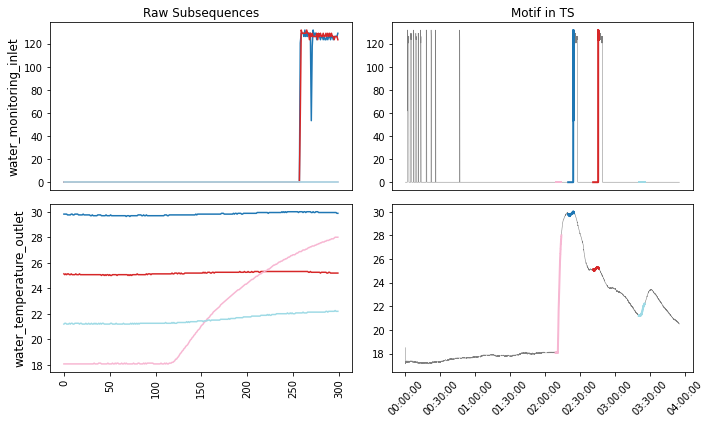

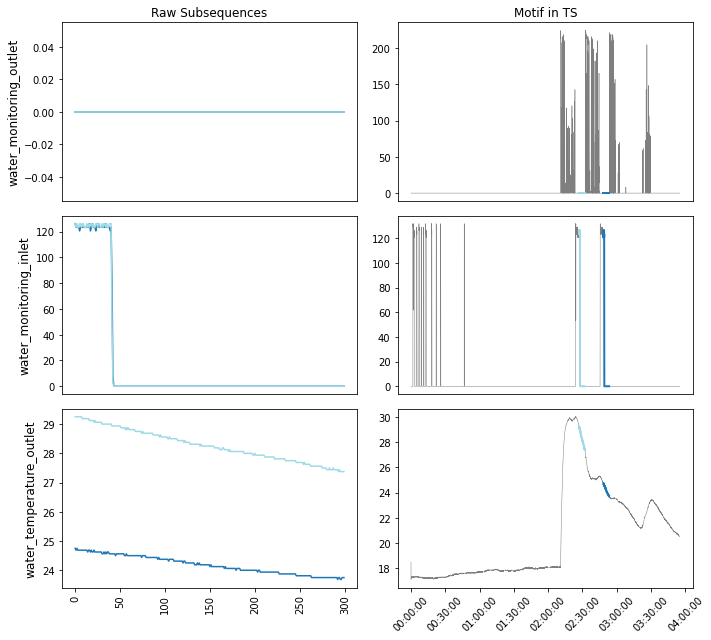

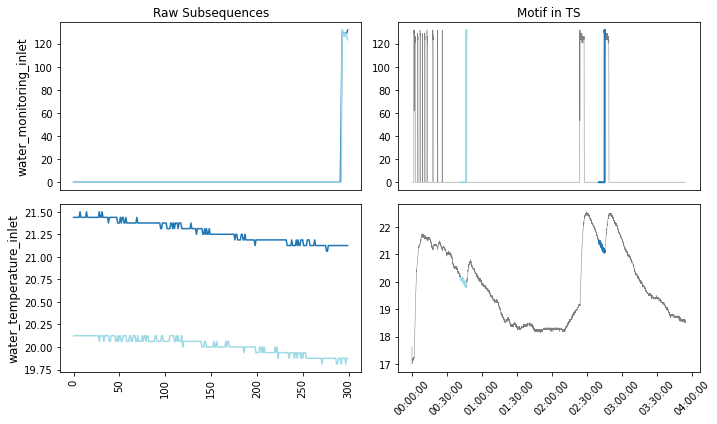

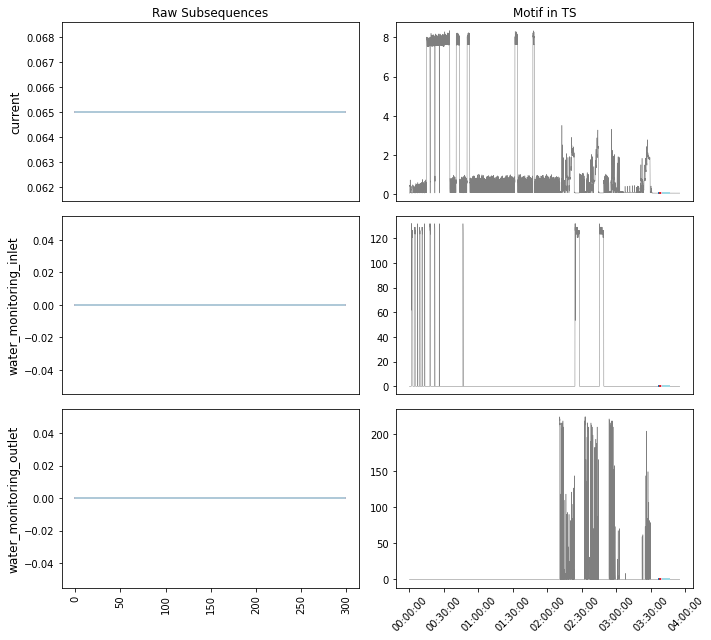

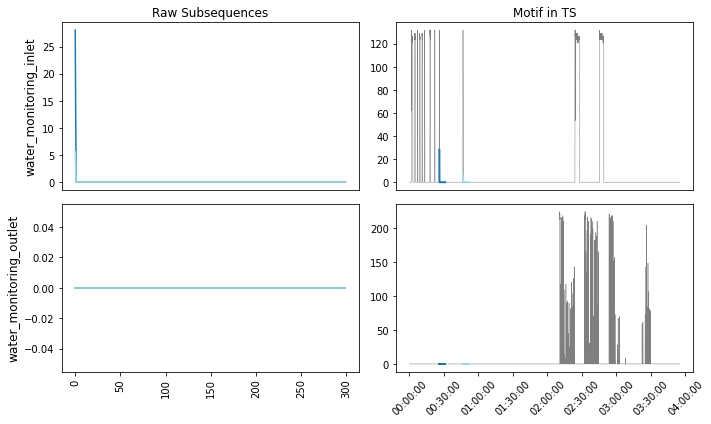

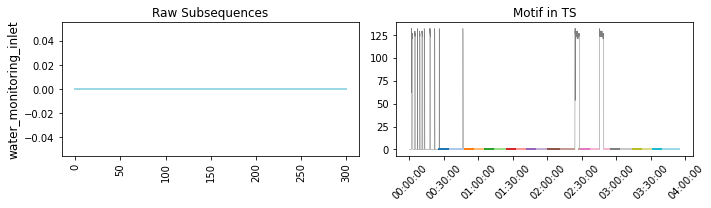

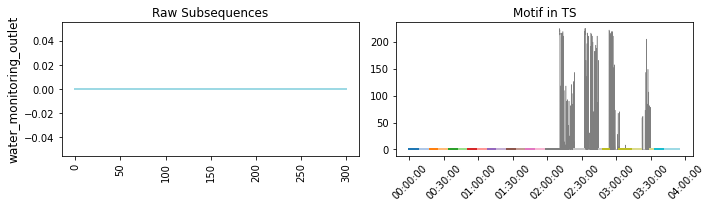

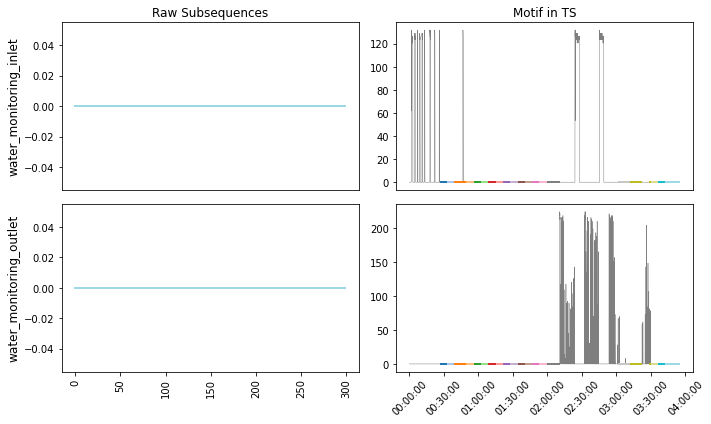

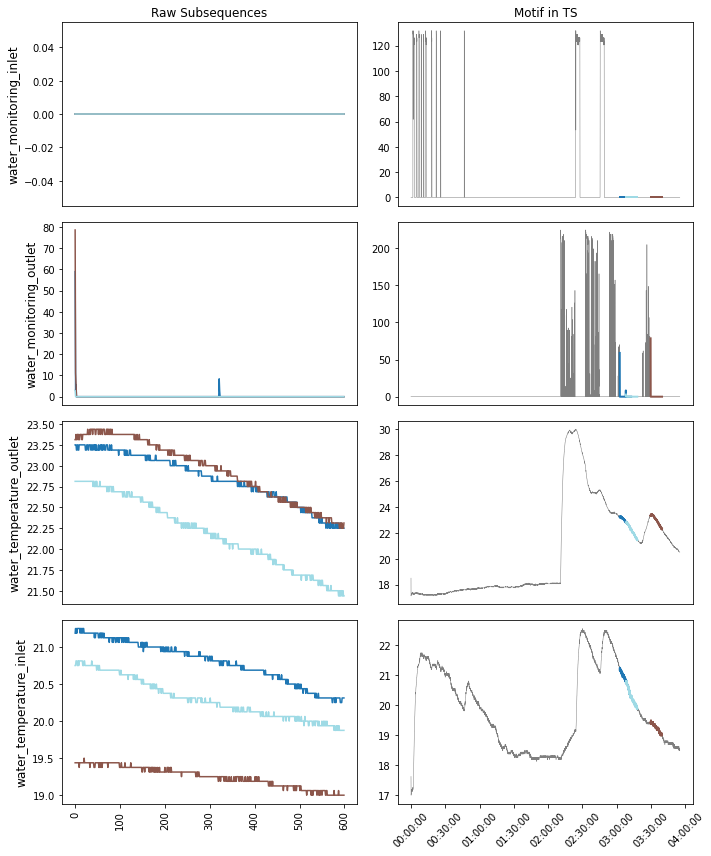

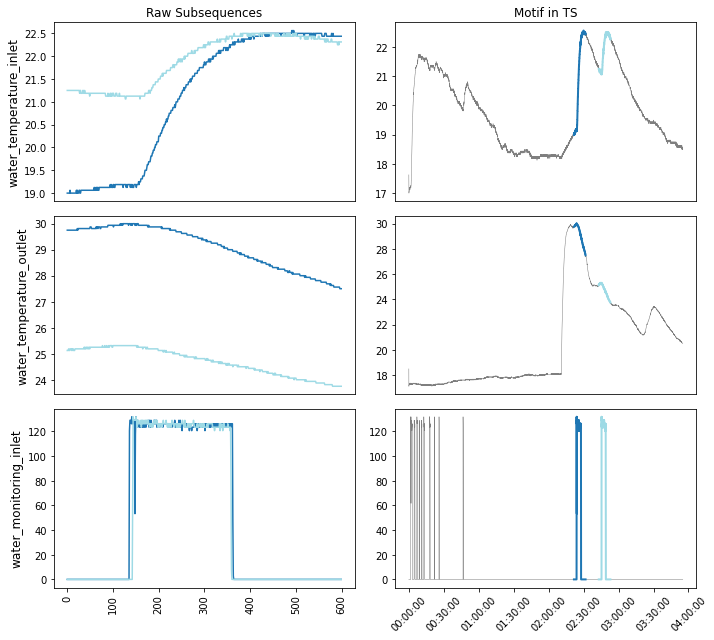

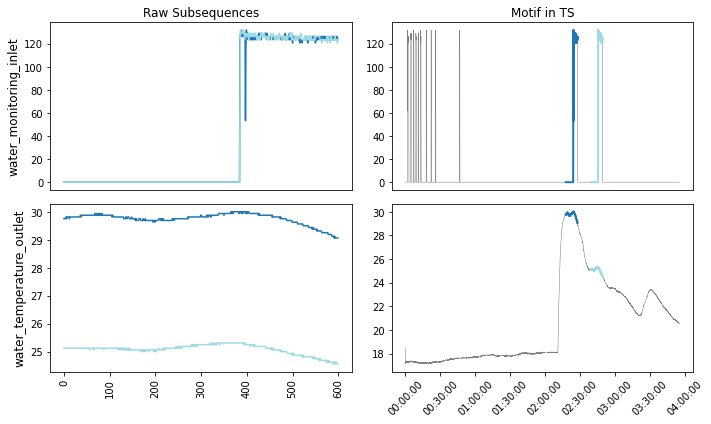

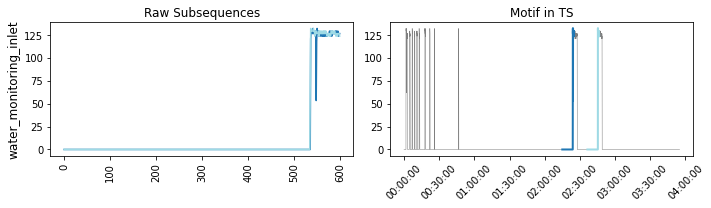

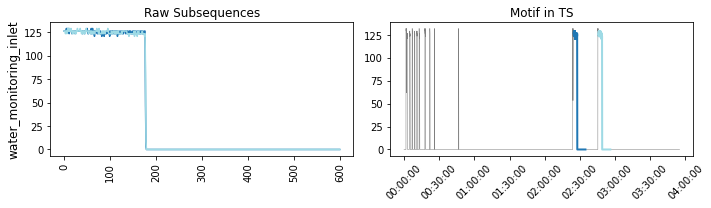

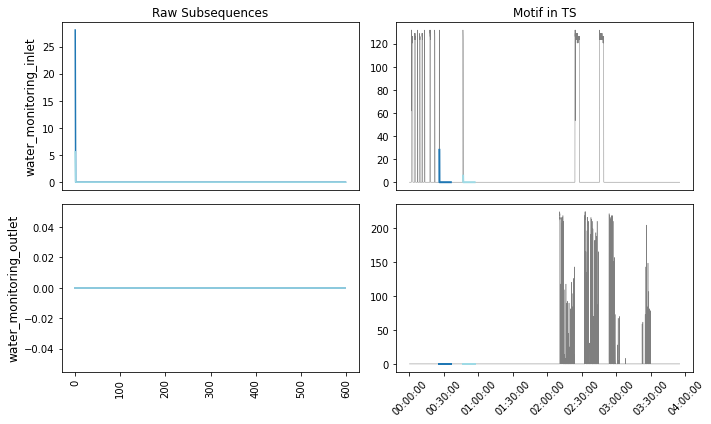

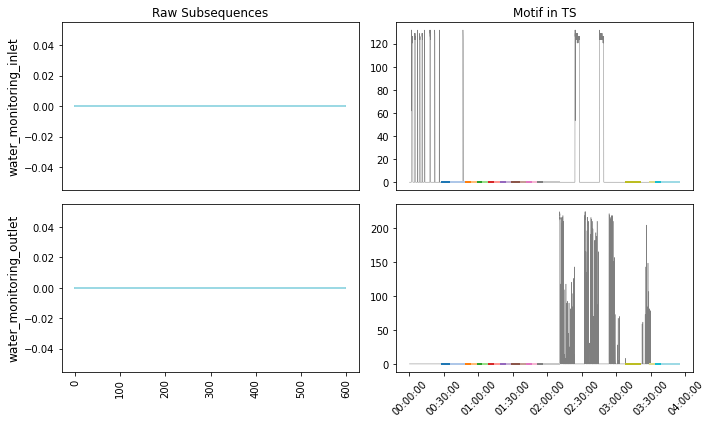

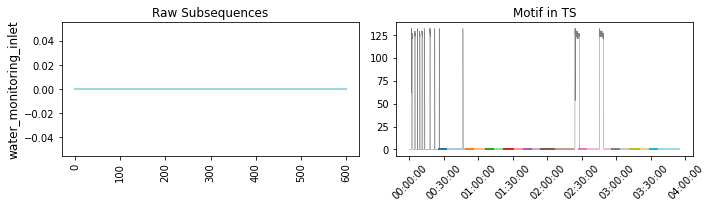

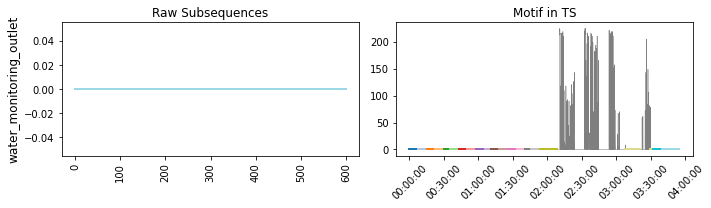

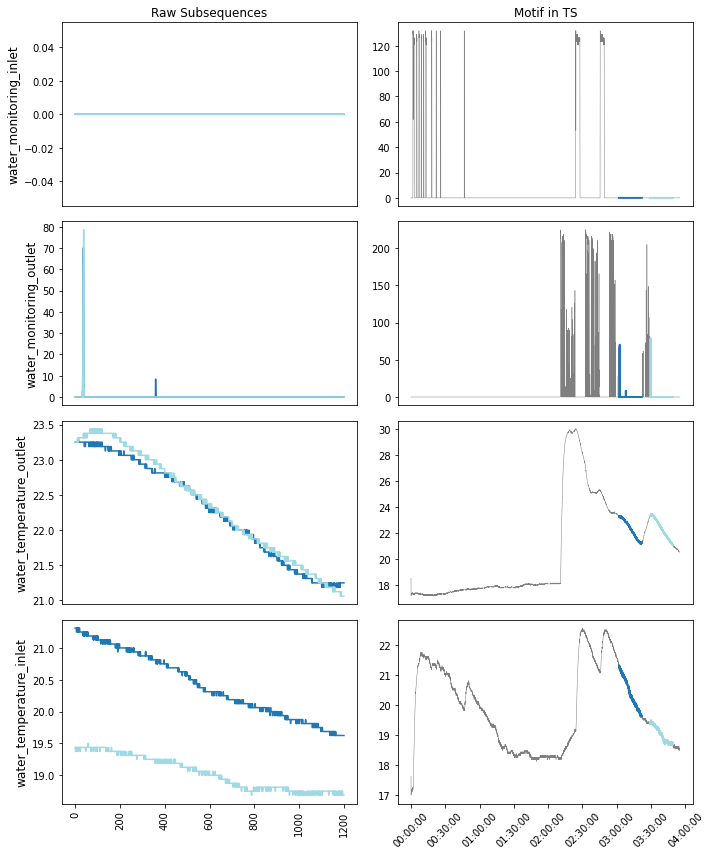

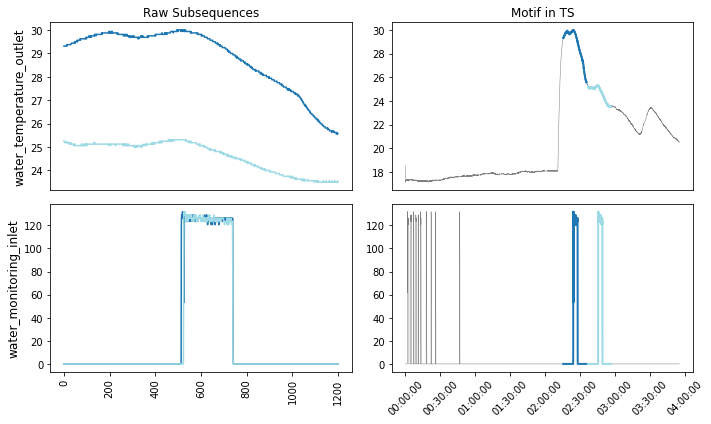

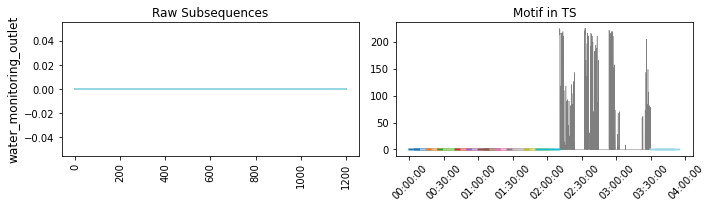

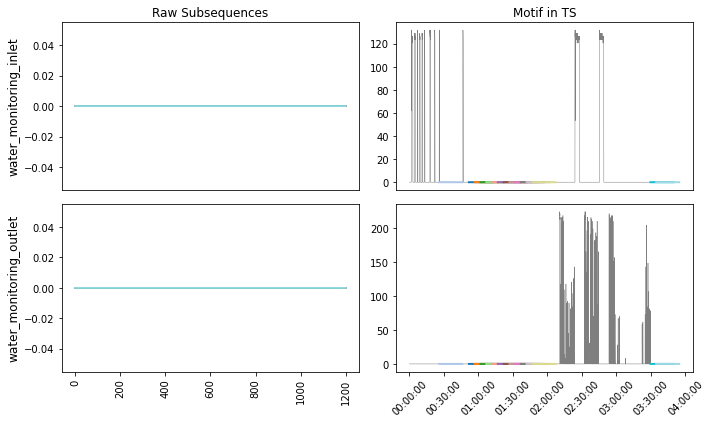

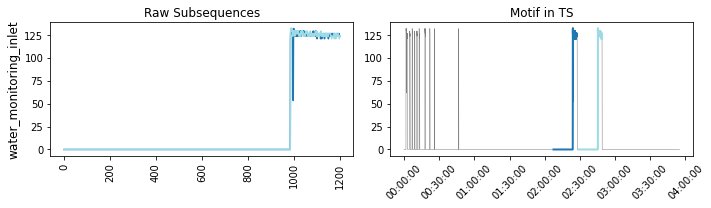

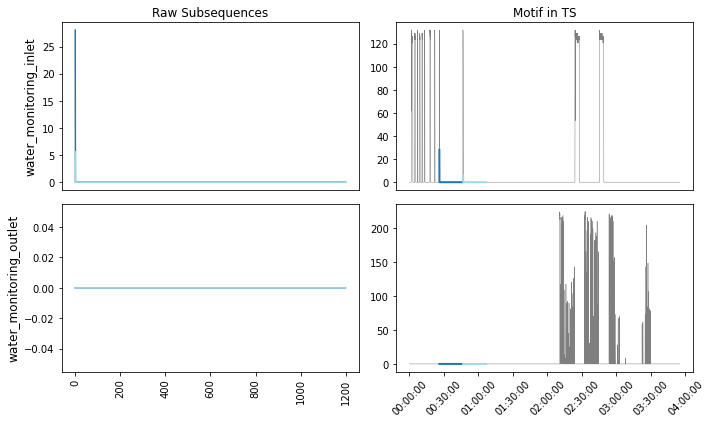

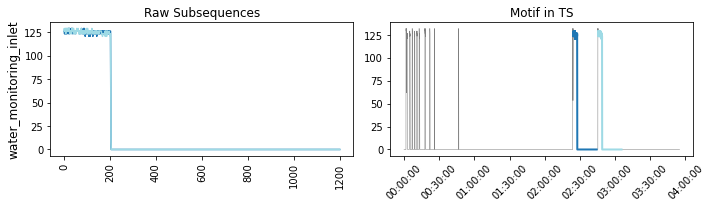

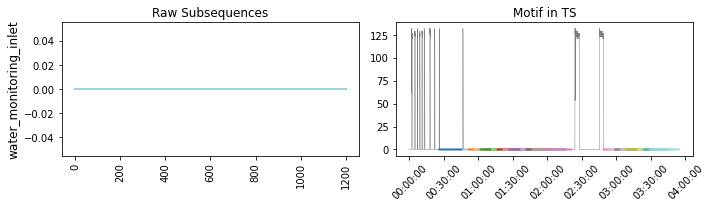

In [31]:
#plot top motif
for m in subsequence_lengths:
    print("Motif length: ", m)
    top_motifs = mp_stats_table[mp_stats_table["m"] == m].sort_values(by="p-value")
    for top_motif in top_motifs.to_dict(orient="records"): 
        m = top_motif["m"]
        dimensions = top_motif["Features"].split(",")
        dimensions = [int(dimension) for dimension in dimensions]
        features = [data.columns[dimension] for dimension in dimensions]
        indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
        indices = [int(i) for i in indices]
        motif_name = top_motif["ID"]
        ts_list = [data[feature] for feature in features]
        plot_motif(ts_list, features, m, indices, motif_name)